**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/LBH.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date    Open       High        Low      Close  Volume  \
0 1999-01-01  6860.0  6933.3333  6833.3333  6860.0000       0   
1 1999-01-04  6820.0  6820.0000  6780.0000  6780.0000     600   
2 1999-01-05  6780.0  6793.3333  6780.0000  6780.0000   14220   
3 1999-01-06  6800.0  7200.0000  6800.0000  7173.3333   69774   
4 1999-01-07  7400.0  8333.3333  7400.0000  7400.0000   51306   

   Earnings Yield (EY)  Dividend Yield (DY)  P:E Ratio (P:E) Trades  \
0                 74.4                 17.7         1.344086      -   
1                 75.3                 18.0         1.328021      -   
2                 75.3                 18.0         1.328021      -   
3                 71.1                 17.1         1.406470      -   
4                 69.0                 16.5         1.449275      -   

  Trade Value  Total Return Index (TRI)  
0           -                     115.0  
1           -                     113.0  
2           -                     113.0  
3           -                     120.0  
4           -                     124.0

**Feature Engineering**

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

#Remove 150 datapoints so no data leakage between hyperparameter optimisation window
df = df[150:]

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
2000-05-11 -0.028798 -0.031749 -0.011546 -0.012821 -0.019170 -0.019170   
2000-05-12 -0.040546 -0.045315 -0.026145 -0.037691 -0.038966 -0.045315   
2000-05-15 -0.028247 -0.046641 -0.001325 -0.027471 -0.039017 -0.040291   
2000-05-16 -0.020203 -0.045611 -0.005319 -0.006645 -0.032790 -0.044336   
2000-05-17 -0.040546 -0.037691  0.006645  0.001325  0.000000 -0.026145   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
2000-05-11 -0.037738 -0.030529 -0.012692  -0.017022  ...     -0.032625   
2000-05-12 -0.039347 -0.035458 -0.019693  -0.022167  ...     -0.036970   
2000-05-15 -0.041221 -0.039185 -0.026826  -0.026616  ...     -0.045315   
2000-05-16 -0.041619 -0.041327 -0.034483  -0.030070  ...     -0.046641   
2000-05-17 -0.041401 -0.040115 -0.038253  -0.031456  ...     -0.045611   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
2000-05-11    -0.031749     -0.031351          -0.031351         -0.018928   
2000-05-12    -0.045315     -0.036970          -0.036970         -0.025642   
2000-05-15    -0.046641     -0.058840          -0.040031         -0.040031   
2000-05-16    -0.039221     -0.040031          -0.040031         -0.027292   
2000-05-17    -0.057759     -0.057894          -0.038966         -0.037691   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
2000-05-11           -0.018928           -0.044171          -0.031749   
2000-05-12           -0.025642           -0.056643          -0.045315   
2000-05-15           -0.040031           -0.046641          -0.046641   
2000-05-16           -0.033682           -0.051960          -0.039221   
2000-05-17           -0.037691           -0.038966          -0.037691   

            Returns Close/High  Returns Open/Low  
Date                                              
2000-05-11           -0.044171         -0.020203  
2000-05-12           -0.056643         -0.025642  
2000-05-15           -0.065450         -0.045315  
2000-05-16           -0.051960         -0.033902  
2000-05-17           -0.057894         -0.044336  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def windowInfo(w, sequencelength, start, trainingSize, validationSize, end):
  '''
  Prints the current window information
  @params:
    w - Window Number
    sequencelength - Length of a single input sequence
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    end - Last datapoint index
  '''
  print('Window ' + str(w + 1) + ': ')
  print('Training datapoints: ' + str(start - sequencelength) + " - " + str(start + trainingSize - 1 - sequencelength))
  print('Validation datapoints: ' + str(start + trainingSize - sequencelength) + " - " + str(start + trainingSize + validationSize - 1 - sequencelength))
  print('Testing datapoints: ' + str(start + trainingSize + validationSize - sequencelength)  + " - " + str(end - 1 - sequencelength))
  print()

def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, predictions, x_train, x_val, x_test):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    predictions - Array that stores predictions across windows
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
  @returns:
    predictions - Updated prediction array
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  #Keep track of overall predictions
  predictions[start - sequencelength: start - sequencelength + testingSize, :] = testingPredictions

  return predictions, trainingPredictions, valPredictions, testingPredictions

def performance(actual, predictions, sett):
  '''
  Calculate the performance metrics for a specific window
  @params:
    actual - True values
    predictions - predicted values
    sett - Training/Validation/Testing set
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print("Results on " + sett + " set: ")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

  return 

def evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, trainingPredictions, valPredictions, testingPredictions):
  '''
  Evaluates the performance of the model
  @params:
    y_trainUnscaled - True Training set values 
    y_valUnscaled - True validation set values
    y_test - True Testing set values
    trainingPredictions - Predicted Training set values 
    valPredictions - Predicted validation set values
    testingPredictions - Predicted Testing set values
  '''
  performance(y_trainUnscaled, trainingPredictions, 'Training')
  performance (y_valUnscaled, valPredictions, 'Validation')
  performance(y_test, testingPredictions, 'Testing')

  return 

**LSTM model**

In [6]:
def create_lstm():
  '''
  Function to create an LSTM using the Keras Framework
  @returns
    model - Compiled LSTM
  '''
  #hyperparameters
  learningRate = 0.01
  dropout = 0.0
  units = 245
  
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(LSTM(units=units, dropout=dropout))
  model.add(Dense(1))

  #LSTM compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_lstm(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 136
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  return history, model

**LSTM Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.001730396931597115
RMSE = 0.04159803999706134
MAE = 0.027833342539165508
R-Squared = -0.061531956939063326

Results on Validation set: 
MSE = 0.000674908806448614
RMSE = 0.025979007033537945
MAE = 0.021443782745966908
R-Squared = 0.04988556567352953

Results on Testing set: 
MSE = 0.0008048210402568564
RMSE = 0.02836936799184741
MAE = 0.023035552647537136
R-Squared = -0.21482143953045618



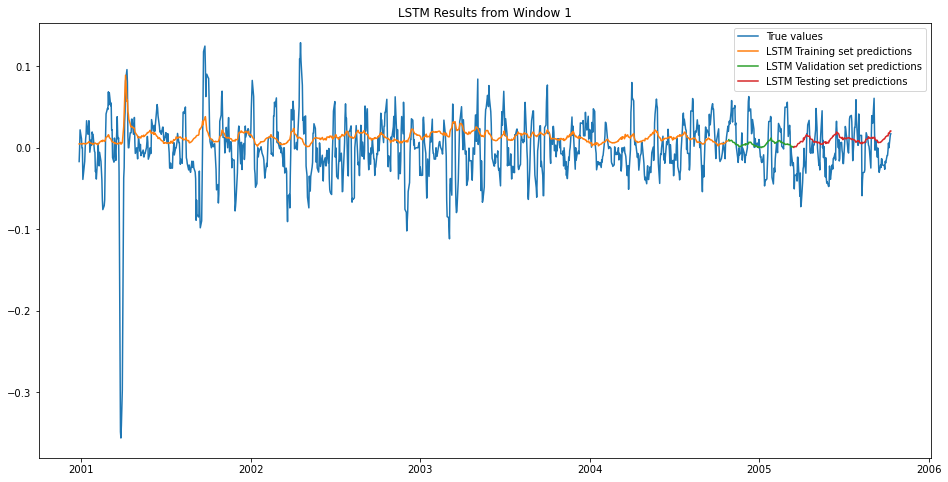

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0010477691765982478
RMSE = 0.03236926283680627
MAE = 0.024537923575902332
R-Squared = 0.029447121562782064

Results on Validation set: 
MSE = 0.0005618337483524977
RMSE = 0.02370303247165851
MAE = 0.019167924837733552
R-Squared = 0.04691733619290683

Results on Testing set: 
MSE = 0.0010582249093960805
RMSE = 0.0325303690325837
MAE = 0.027245282131165616
R-Squared = -0.31900336378670957



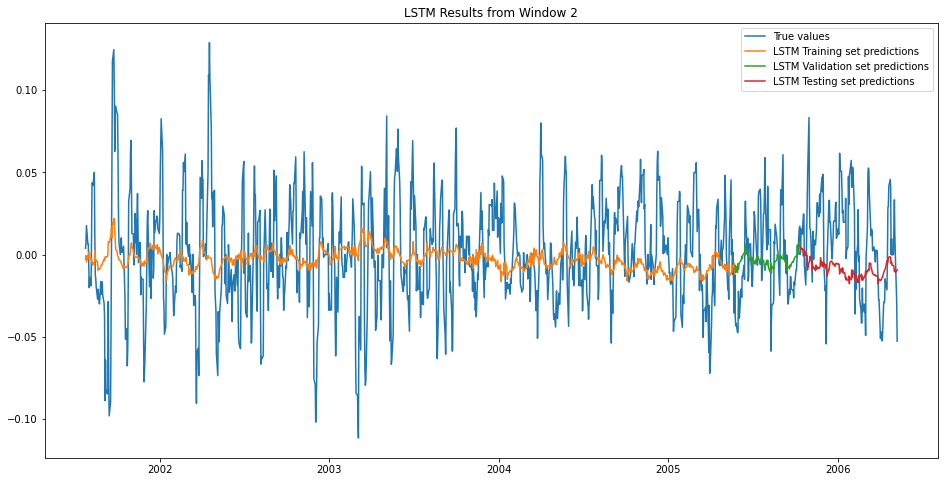

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0006783840275961798
RMSE = 0.026045806334152523
MAE = 0.019126409626601105
R-Squared = 0.26866815954562673

Results on Validation set: 
MSE = 0.000744510340716595
RMSE = 0.027285716789496203
MAE = 0.019983261221784957
R-Squared = 0.1896570687712814

Results on Testing set: 
MSE = 0.0012054637630348898
RMSE = 0.03471978921357228
MAE = 0.026670151424080874
R-Squared = -0.07449224745598682



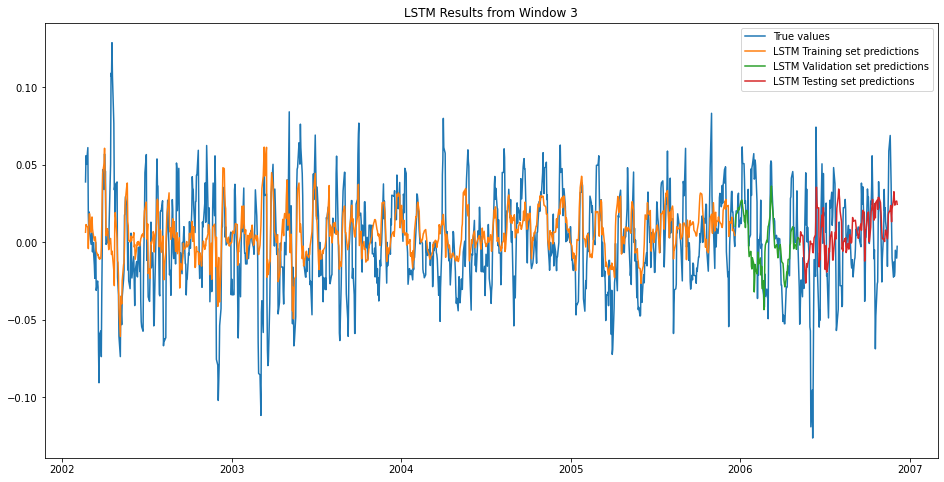

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0008305499050314739
RMSE = 0.028819262742677404
MAE = 0.02207740531894867
R-Squared = 0.08047819192118133

Results on Validation set: 
MSE = 0.0006657767602437202
RMSE = 0.02580265025619888
MAE = 0.0203457272172371
R-Squared = 0.03752000496174446

Results on Testing set: 
MSE = 0.0010796428818771354
RMSE = 0.03285791962186796
MAE = 0.026493521721603533
R-Squared = -0.1886916361816824



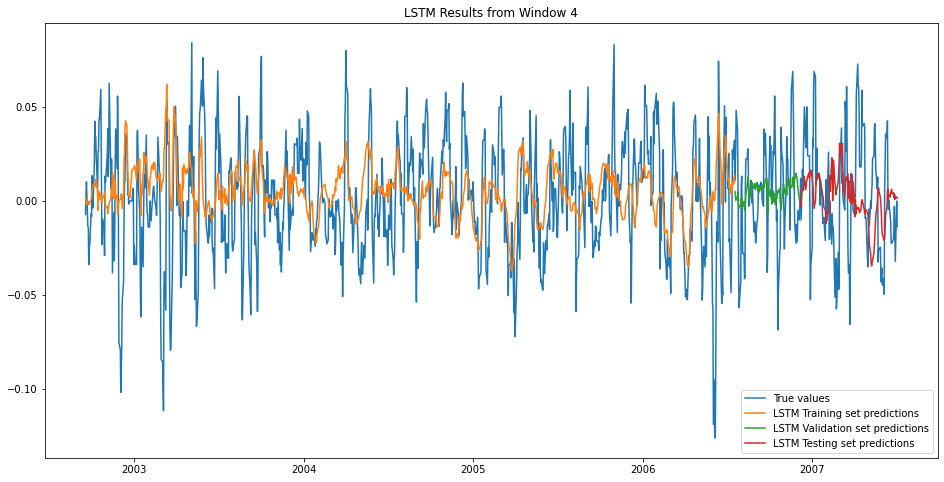

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0008342469425735308
RMSE = 0.028883333300945908
MAE = 0.02267595144489494
R-Squared = -0.02193441798713658

Results on Validation set: 
MSE = 0.0009818216508710035
RMSE = 0.03133403342806354
MAE = 0.02578120798840198
R-Squared = 0.01326048691104309

Results on Testing set: 
MSE = 0.0011286817311927184
RMSE = 0.03359585883993321
MAE = 0.02629466018601465
R-Squared = -0.039446653599216175



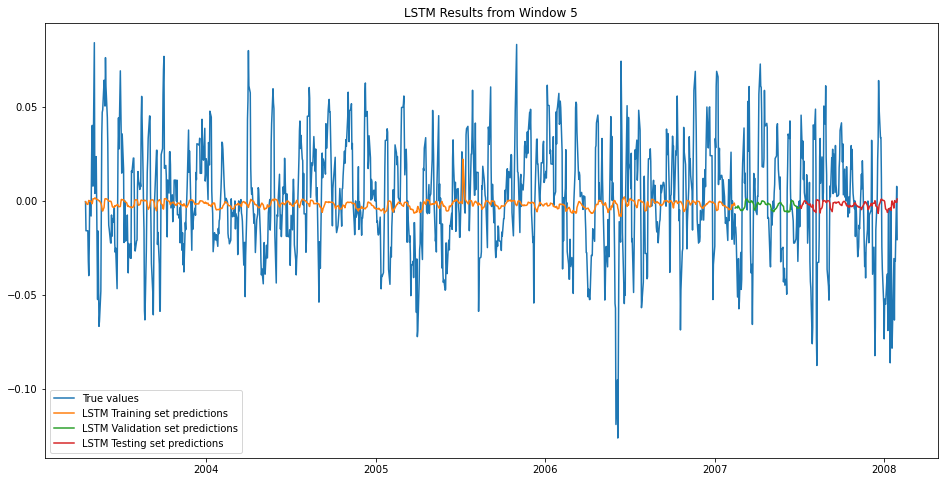

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0008688620910509856
RMSE = 0.029476466732819007
MAE = 0.023416535104679014
R-Squared = -0.049539192590468684

Results on Validation set: 
MSE = 0.0010048637656885576
RMSE = 0.031699586206897994
MAE = 0.02476601691861814
R-Squared = -0.02082055478601319

Results on Testing set: 
MSE = 0.0022834610418179693
RMSE = 0.04778557357422813
MAE = 0.03067180614518054
R-Squared = -0.026631899846742746



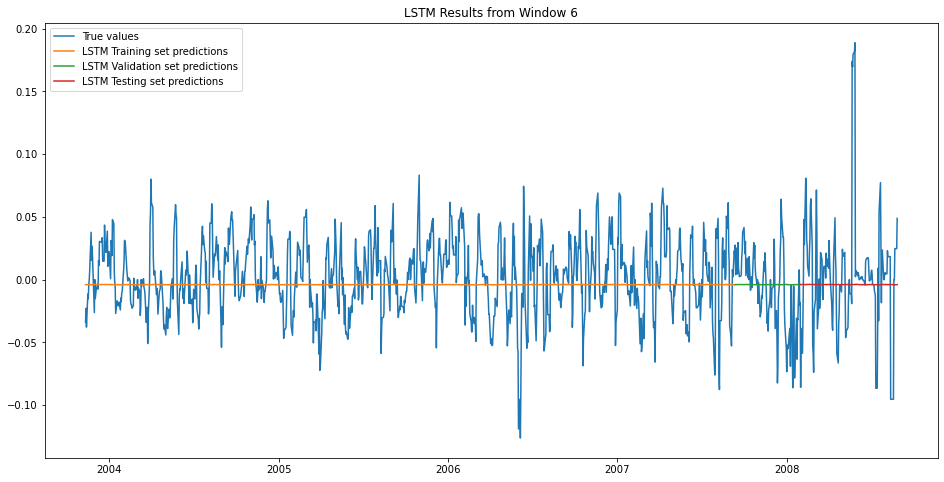

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0009135254259050927
RMSE = 0.03022458313864879
MAE = 0.02382329267772972
R-Squared = 0.0005679557463957874

Results on Validation set: 
MSE = 0.0026596314254151055
RMSE = 0.05157161453178585
MAE = 0.0297113862036882
R-Squared = -0.0013366086301409563

Results on Testing set: 
MSE = 0.003769998265442182
RMSE = 0.06140031160704465
MAE = 0.045515415141989216
R-Squared = -0.006162061370206473



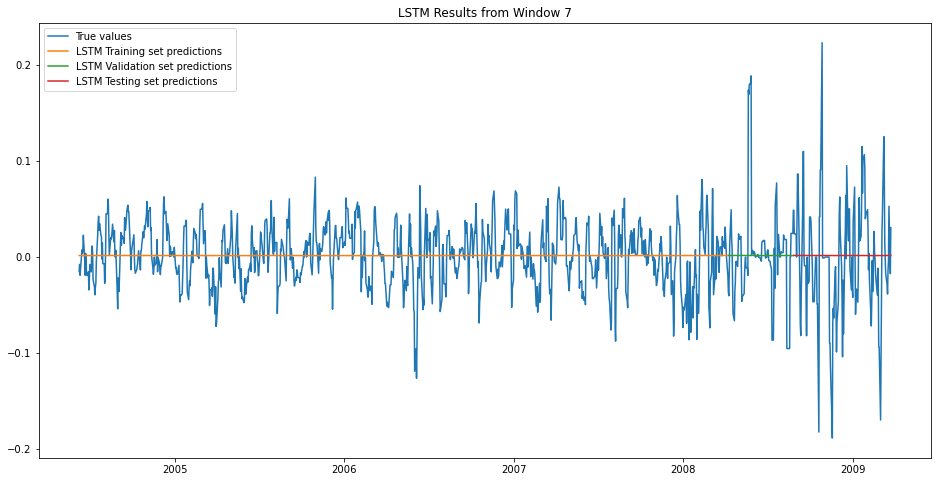

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.001336404756644852
RMSE = 0.03655687017025462
MAE = 0.027139733988676532
R-Squared = -0.04245243215713401

Results on Validation set: 
MSE = 0.0035761094239833025
RMSE = 0.05980058046527059
MAE = 0.045635676480789866
R-Squared = -0.0009834319203558817

Results on Testing set: 
MSE = 0.0016354307231140155
RMSE = 0.040440458987430095
MAE = 0.031563631519440714
R-Squared = -0.05429401694965308



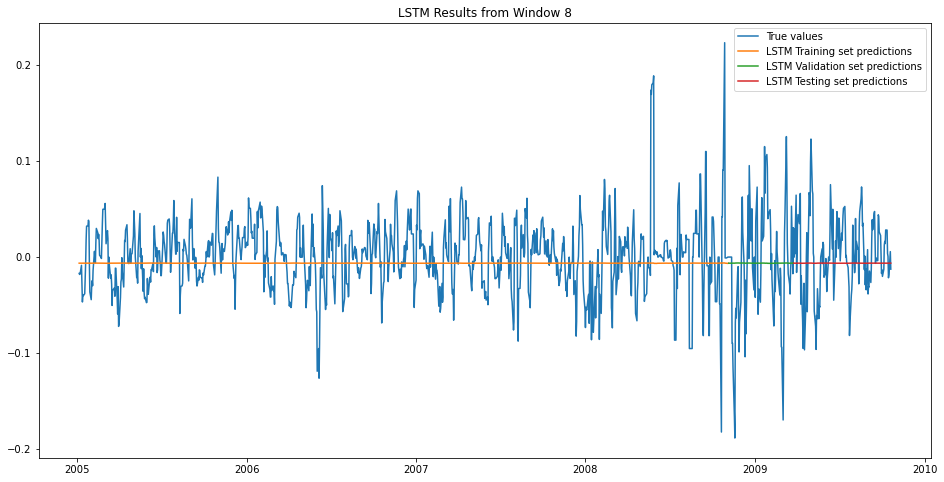

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0015934621246323324
RMSE = 0.039918192902889935
MAE = 0.028983441500677696
R-Squared = 0.04723484940930878

Results on Validation set: 
MSE = 0.0008396269770388498
RMSE = 0.028976317520327696
MAE = 0.023463558653477844
R-Squared = 0.04838203547656139

Results on Testing set: 
MSE = 0.0010631647016824397
RMSE = 0.03260620649021348
MAE = 0.026284465900757278
R-Squared = 0.05601521015961475



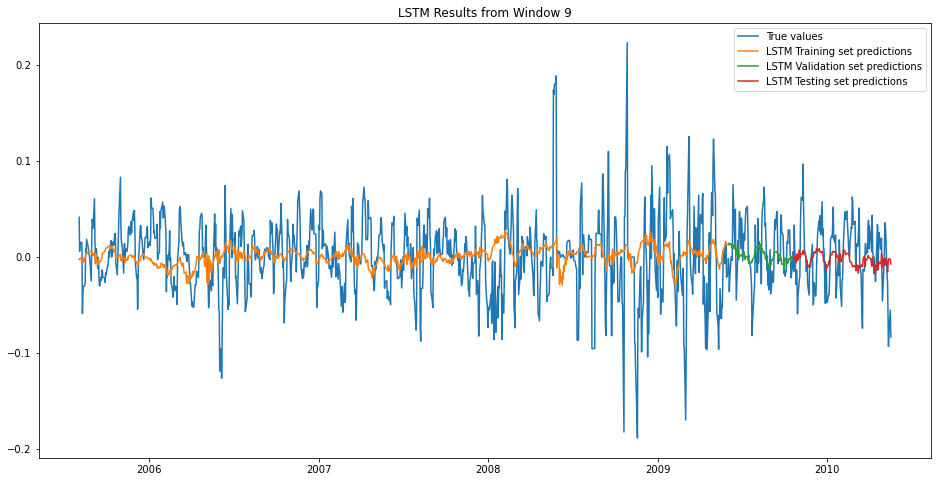

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.001819127350577352
RMSE = 0.04265122918014617
MAE = 0.03089827162756239
R-Squared = -0.06309203411580833

Results on Validation set: 
MSE = 0.0011173384590690452
RMSE = 0.03342661303615796
MAE = 0.026523125192382938
R-Squared = -0.012260299867987046

Results on Testing set: 
MSE = 0.0007249098940738446
RMSE = 0.02692415075863758
MAE = 0.02097881417958371
R-Squared = -0.026923211260194257



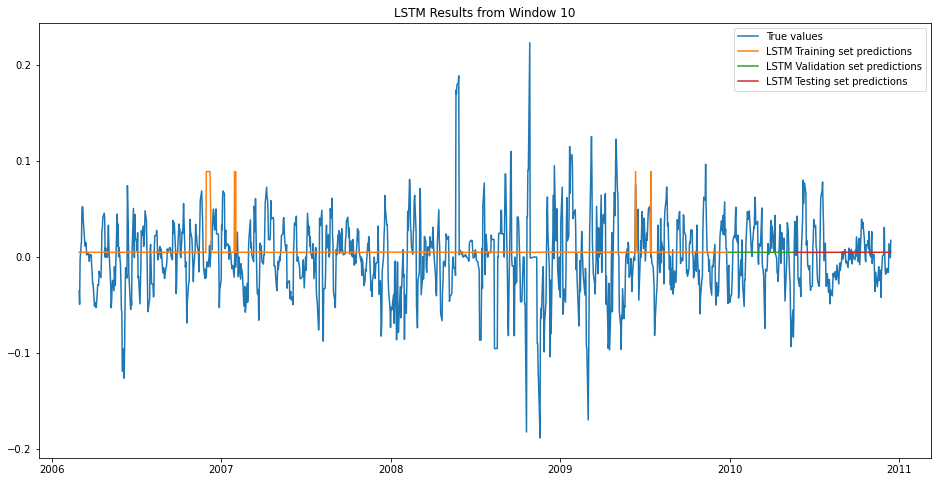

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.001652118916815337
RMSE = 0.040646265717964015
MAE = 0.03029045157680611
R-Squared = 0.03844979761799294

Results on Validation set: 
MSE = 0.0003105647138433304
RMSE = 0.01762284636043027
MAE = 0.014187625090725697
R-Squared = 0.07117697880090412

Results on Testing set: 
MSE = 0.00053123044697917
RMSE = 0.02304843697475319
MAE = 0.016964213962363354
R-Squared = 0.04455606265766554



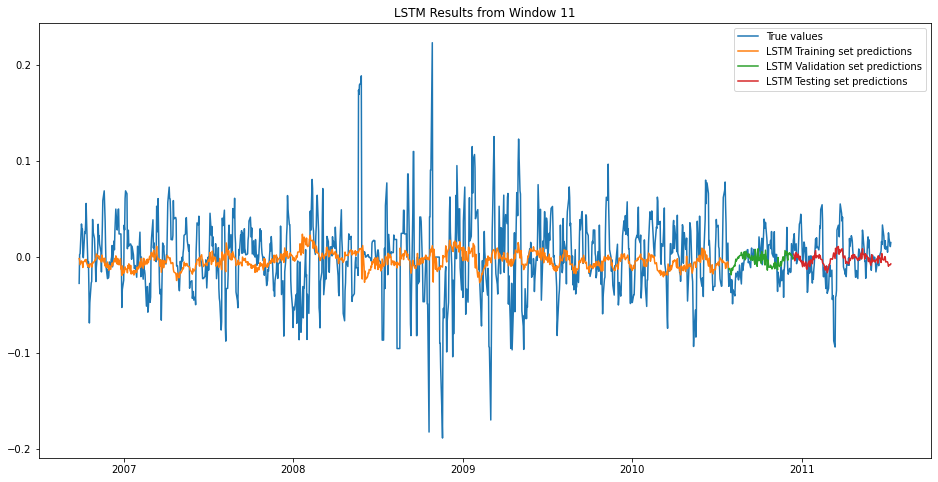

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.001573464468588327
RMSE = 0.039666919071038614
MAE = 0.028696755064700454
R-Squared = 0.03708234562473822

Results on Validation set: 
MSE = 0.0005724247520609487
RMSE = 0.023925399726252197
MAE = 0.017325877793081486
R-Squared = -0.007180536356527822

Results on Testing set: 
MSE = 0.000379424798425374
RMSE = 0.01947882949320554
MAE = 0.01550514310073836
R-Squared = -0.015032071462215857



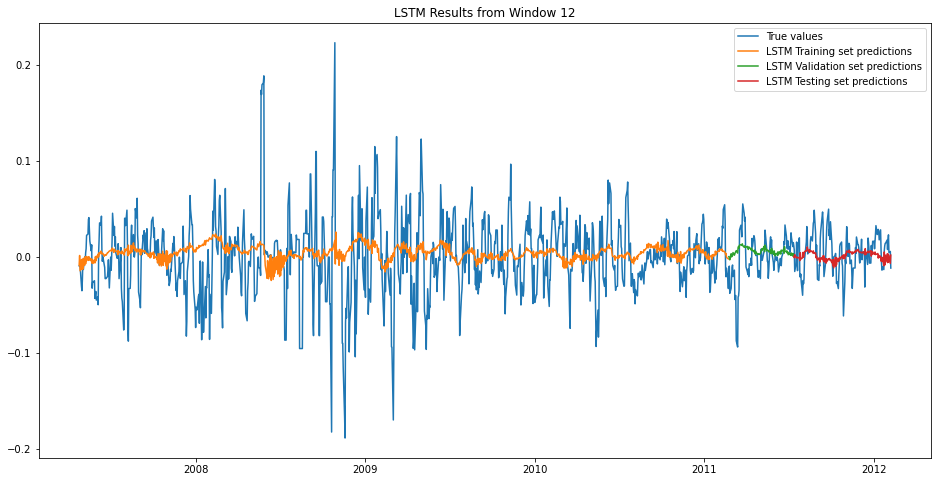

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0016344482392695748
RMSE = 0.040428309874017423
MAE = 0.02878742073506921
R-Squared = -0.018315870918439003

Results on Validation set: 
MSE = 0.00031987836998186345
RMSE = 0.017885143834531034
MAE = 0.013823669710052439
R-Squared = 0.026077364808856474

Results on Testing set: 
MSE = 0.00033235371340789403
RMSE = 0.01823057084701118
MAE = 0.01473844371692742
R-Squared = -0.07793407438501343



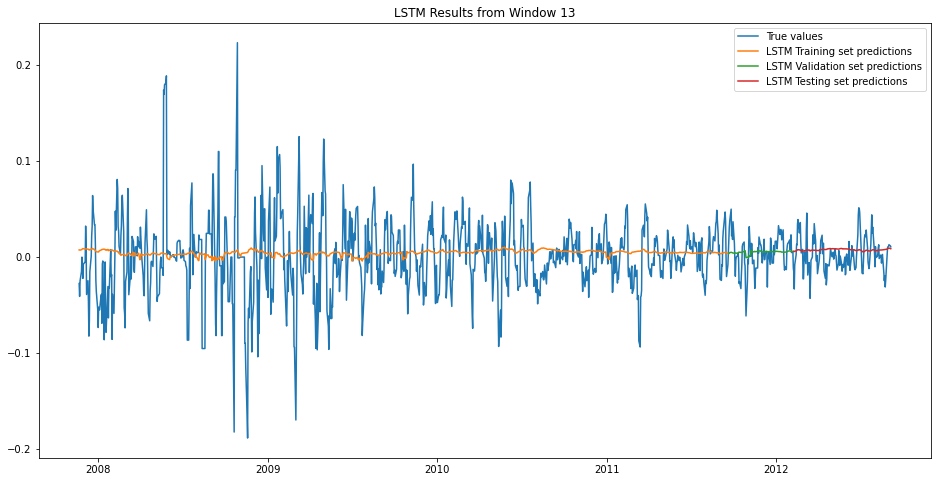

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0010713006443906245
RMSE = 0.032730729359282916
MAE = 0.023131299130893488
R-Squared = 0.18599837351604298

Results on Validation set: 
MSE = 0.00021443794337763756
RMSE = 0.014643699784468322
MAE = 0.01170457479925383
R-Squared = 0.20757330207754598

Results on Testing set: 
MSE = 0.0007279472491379833
RMSE = 0.026980497570244757
MAE = 0.02164637906071971
R-Squared = -0.2928372014042018



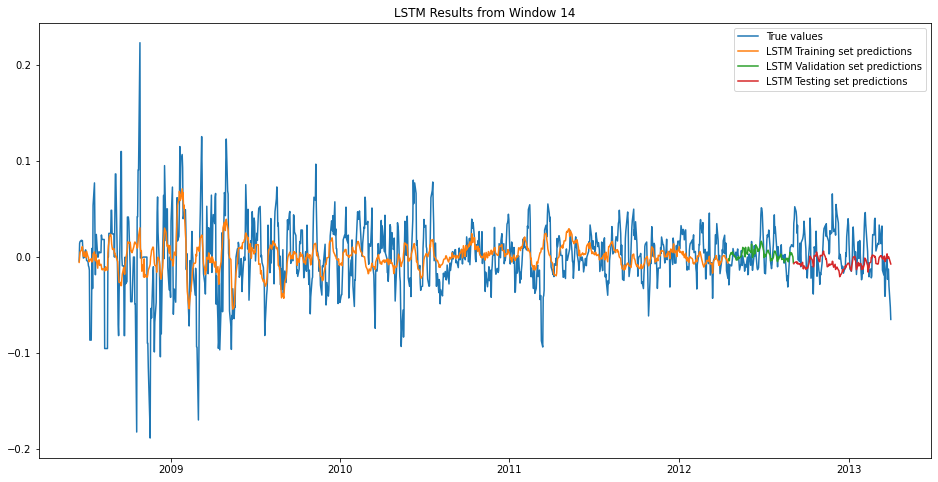

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0008828458679371713
RMSE = 0.029712722324572876
MAE = 0.02195241035426104
R-Squared = 0.01330485900677103

Results on Validation set: 
MSE = 0.0005780851996855844
RMSE = 0.024043402414915913
MAE = 0.019803644848535622
R-Squared = 0.01005449507217504

Results on Testing set: 
MSE = 0.0011144282383909424
RMSE = 0.03338305316161094
MAE = 0.02643097644822432
R-Squared = -0.03312127808326548



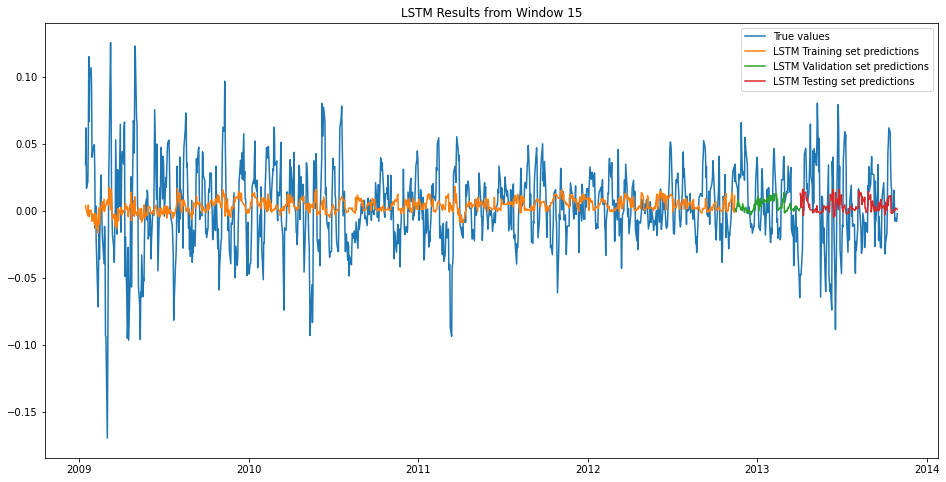

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0006726915545226612
RMSE = 0.025936298011139933
MAE = 0.020098943971504548
R-Squared = -0.009215446557835572

Results on Validation set: 
MSE = 0.0008598085111647406
RMSE = 0.02932249155792769
MAE = 0.02333941673158203
R-Squared = -0.001874125998872156

Results on Testing set: 
MSE = 0.0006001554624144517
RMSE = 0.024498070585547174
MAE = 0.018222400383593653
R-Squared = -0.0014718995691314074



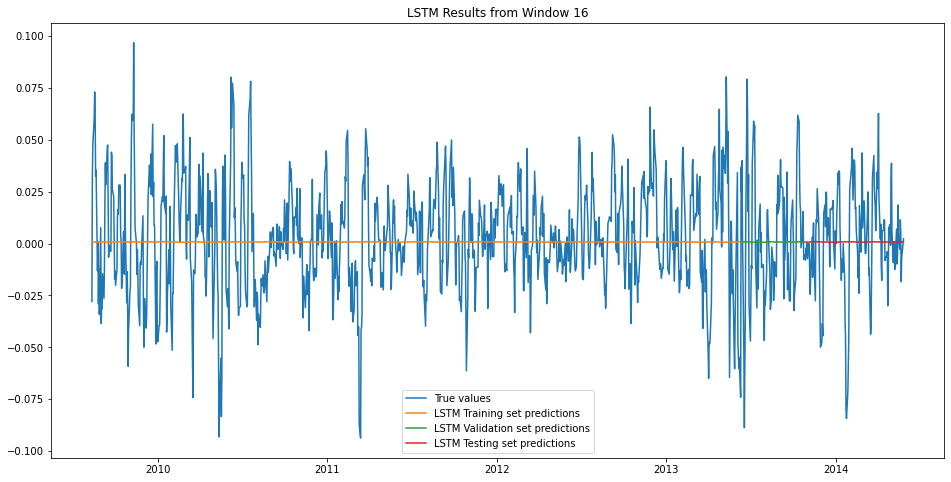

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0004675238539350956
RMSE = 0.02162229992242027
MAE = 0.0163537019359177
R-Squared = 0.25415331247016215

Results on Validation set: 
MSE = 0.0007325526739209723
RMSE = 0.027065710297735995
MAE = 0.018545705203089534
R-Squared = -0.045564899224167066

Results on Testing set: 
MSE = 0.0007036929196523409
RMSE = 0.02652721092863592
MAE = 0.02140248678704872
R-Squared = -0.3986758124805394



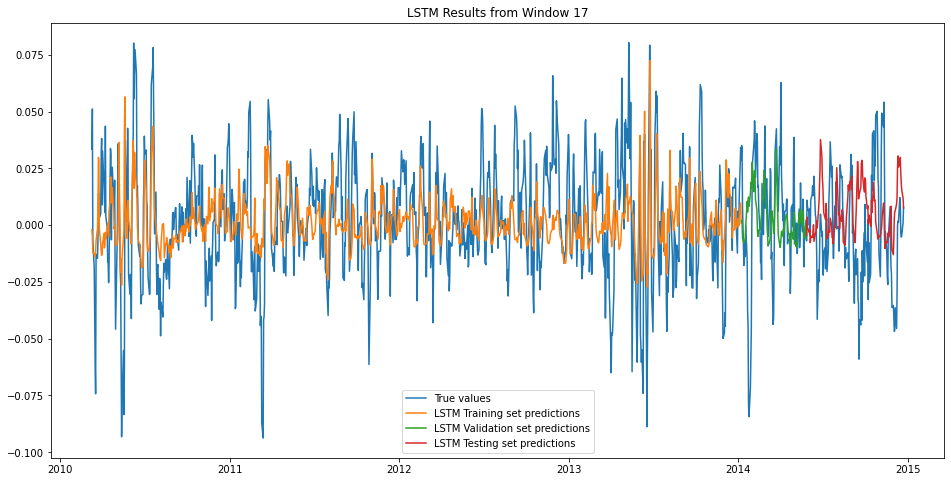

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0007687219887772727
RMSE = 0.027725836124042728
MAE = 0.01792040752000718
R-Squared = -0.38131466867618413

Results on Validation set: 
MSE = 0.0006028190814035577
RMSE = 0.024552374251863254
MAE = 0.020306677657647914
R-Squared = 0.051130262535932225

Results on Testing set: 
MSE = 0.03521485856312203
RMSE = 0.187656224418808
MAE = 0.14824420522283607
R-Squared = -34.22712440413857



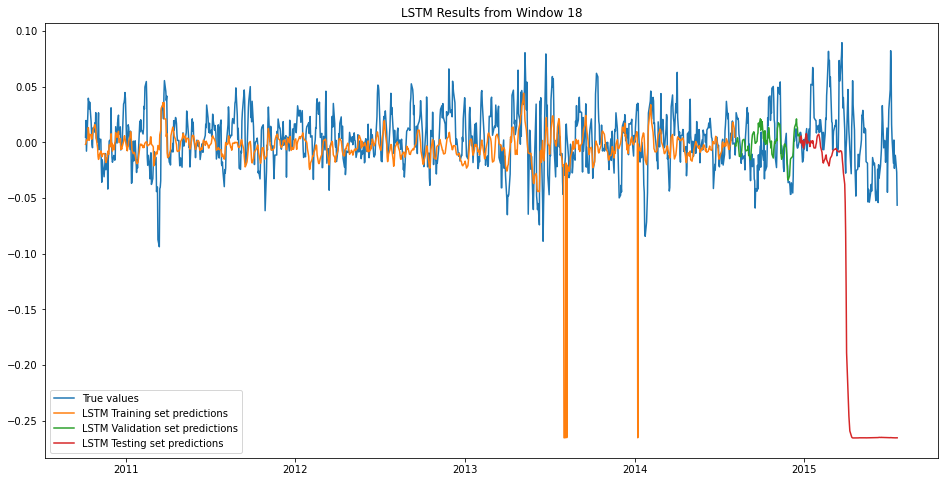

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0005524272646225461
RMSE = 0.023503771285105418
MAE = 0.018055555184606796
R-Squared = 0.03478010837633372

Results on Validation set: 
MSE = 0.0010717225550388758
RMSE = 0.03273717390122238
MAE = 0.026210693676495474
R-Squared = -0.01288764011360577

Results on Testing set: 
MSE = 0.001665128828250149
RMSE = 0.04080599010255907
MAE = 0.031836932347462564
R-Squared = -0.07204270528842294



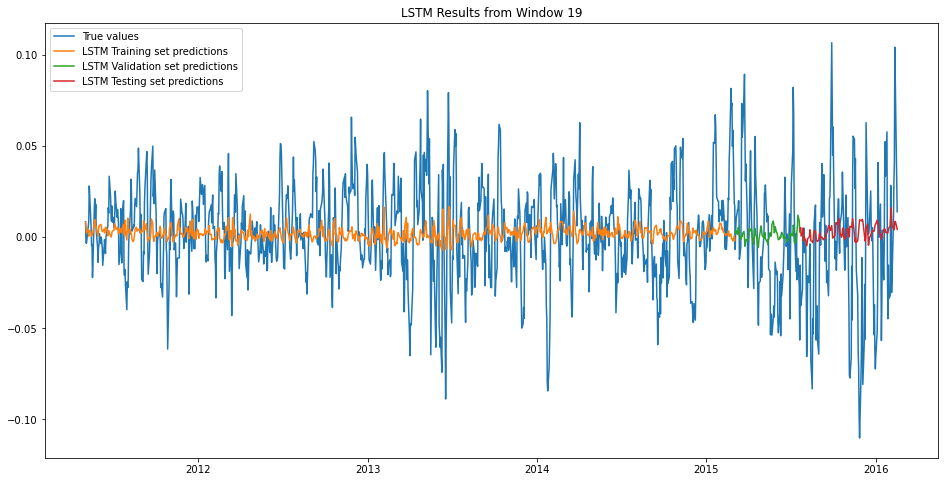

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.000726860510921977
RMSE = 0.02696035071956552
MAE = 0.020666771361329758
R-Squared = -0.035392661877815756

Results on Validation set: 
MSE = 0.0016856221966566913
RMSE = 0.04105632955655792
MAE = 0.0324705424715298
R-Squared = -0.008104704591138212

Results on Testing set: 
MSE = 0.0015457570497545456
RMSE = 0.03931611692111195
MAE = 0.030685772577288474
R-Squared = -0.004717932245573042



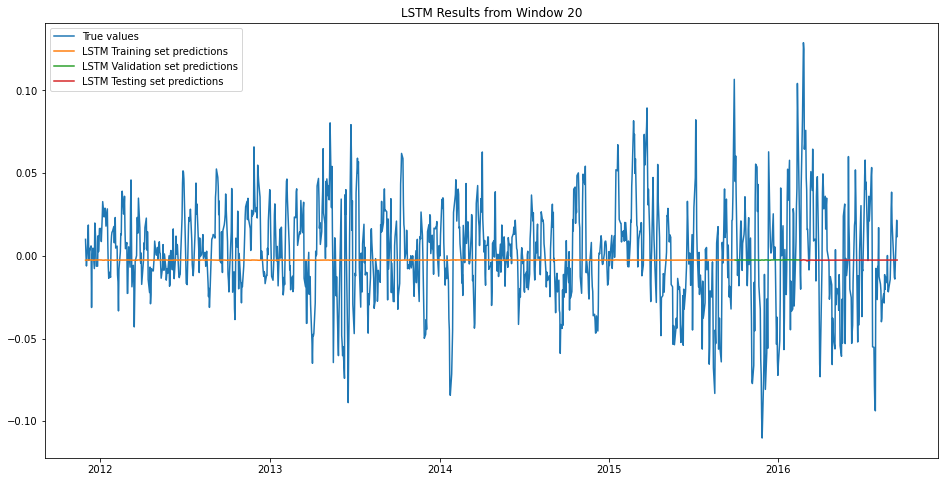

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0008256923160585367
RMSE = 0.028734862381061384
MAE = 0.022136799544739787
R-Squared = 0.1301248853739746

Results on Validation set: 
MSE = 0.0012258695588295483
RMSE = 0.03501242006530751
MAE = 0.026248531747465186
R-Squared = -0.1433188928266198

Results on Testing set: 
MSE = 0.0014451061612122944
RMSE = 0.03801455196648113
MAE = 0.029587096874821354
R-Squared = -0.18784767725632978



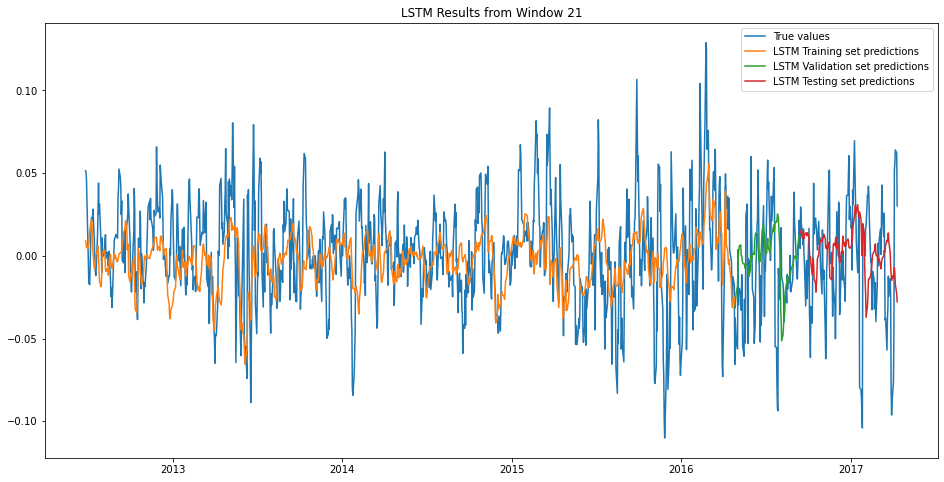

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0009779408942396568
RMSE = 0.031272046531042014
MAE = 0.024104106834578164
R-Squared = 0.046274570789957226

Results on Validation set: 
MSE = 0.001583350647467992
RMSE = 0.03979133884990541
MAE = 0.03034629974981337
R-Squared = -0.06554684738362804

Results on Testing set: 
MSE = 0.0006544934885057849
RMSE = 0.025583070349467142
MAE = 0.020300210811789565
R-Squared = 0.0018428207768915739



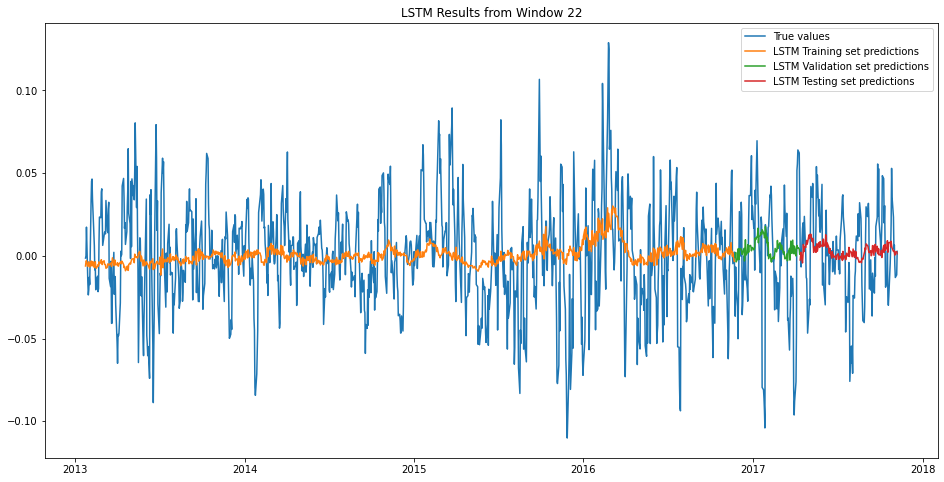

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0009878939289621048
RMSE = 0.031430779961084405
MAE = 0.02353602014005839
R-Squared = 0.04818959778981269

Results on Validation set: 
MSE = 0.0006792474839745891
RMSE = 0.026062376790588173
MAE = 0.020387820125743403
R-Squared = 0.03522151487111336

Results on Testing set: 
MSE = 0.00139560698167198
RMSE = 0.03735782356711884
MAE = 0.029022024511549567
R-Squared = -0.01329058339639011



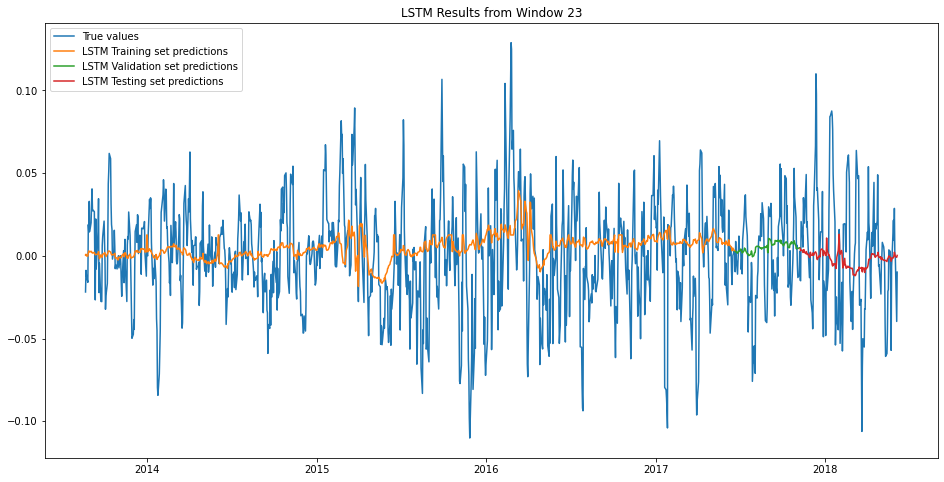

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0010942941152530356
RMSE = 0.03308011661486452
MAE = 0.025193420911678335
R-Squared = -0.0006044144162307141

Results on Validation set: 
MSE = 0.0012129692204640389
RMSE = 0.03482770765445293
MAE = 0.027399577068789968
R-Squared = -0.007338480461124286

Results on Testing set: 
MSE = 0.0010694762242943639
RMSE = 0.03270284734230895
MAE = 0.02584238591826146
R-Squared = -0.010888018980409031



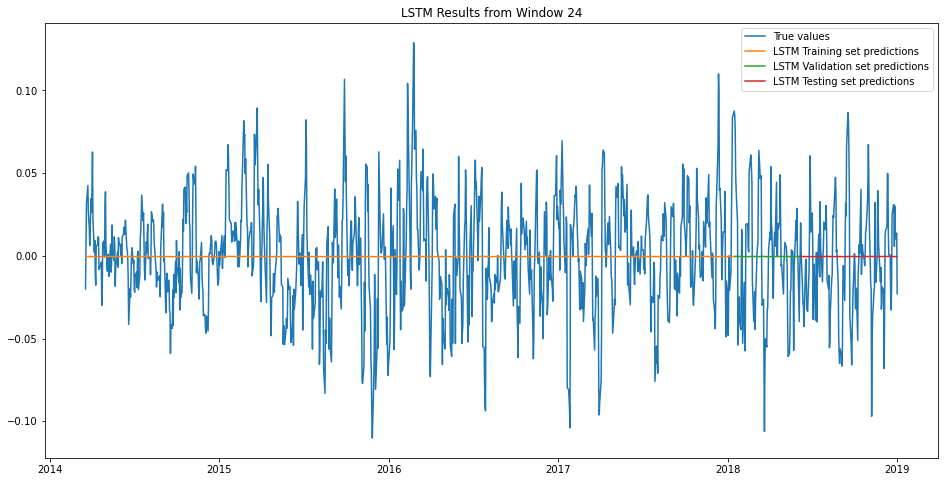

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4954

Results on Training set: 
MSE = 0.001046482940524617
RMSE = 0.032349388564926806
MAE = 0.02453941155644897
R-Squared = 0.12319683920669078

Results on Validation set: 
MSE = 0.0010406826709695402
RMSE = 0.03225961362089664
MAE = 0.026009828093454167
R-Squared = 0.18090702619614618

Results on Testing set: 
MSE = 0.0008434842391052328
RMSE = 0.029042800125078035
MAE = 0.023113248288534817
R-Squared = -0.05301540879844757



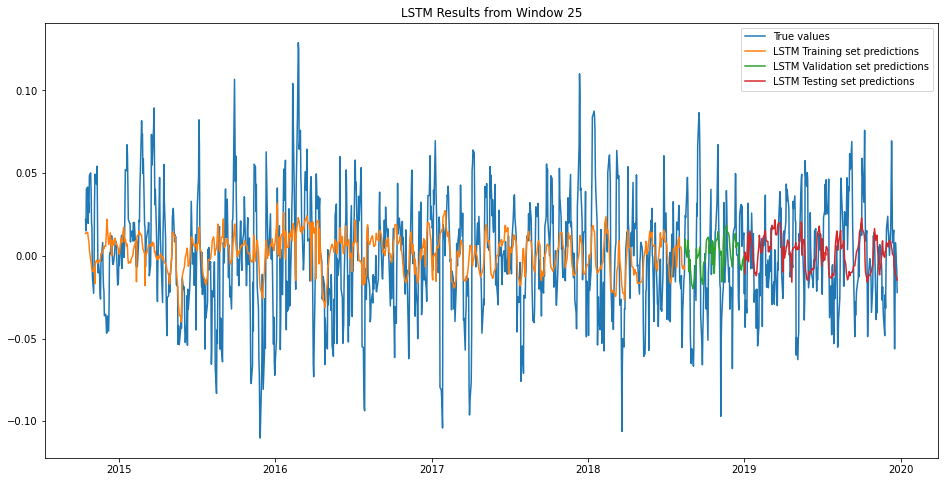

In [7]:
dataset = df.values
totaldatapoints = len(dataset)

#Declaring model parameters
sequencelength = 164
features = len(df.columns) - 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
lstm_predictions = np.zeros((numPredictions + extra,1)) 
lstm_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test LSTM
  lstm_model = create_lstm()
  lstm_history, lstm_model = train_lstm(lstm_model, x_train, y_train, x_val, y_val)
  lstm_predictions, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions = makePredictions(lstm_model, lstm_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions)

  lstm_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['LSTM Train Predictions'] = lstm_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['LSTM Val Predictions'] = lstm_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['LSTM Test Predictions'] = lstm_testingPredictions

  #Plot LSTM Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['LSTM Train Predictions'], label = 'LSTM Training set predictions')
  plt.plot(valGraph['LSTM Val Predictions'], label = 'LSTM Validation set predictions')
  plt.plot(testGraph['LSTM Test Predictions'], label = 'LSTM Testing set predictions')
  plt.title("LSTM Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

In [8]:
K.clear_session()
tf.compat.v1.reset_default_graph()

**GRU model**

In [9]:
def create_gru():
  '''
  Function to create an GRU using the Keras Framework
  @returns
    model - Compiled GRU
  '''
  #hyperparameters
  learningRate = 0.00017251634820341426
  dropout = 0.1402865260291588
  units = 132

  #Construct GRU
  model = Sequential()
  model.add(GRU(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(GRU(units=units, dropout=dropout))
  model.add(Dense(1))

  #GRU compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_gru(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 1
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  return history, model

**GRU Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0010381734110141432
RMSE = 0.03222069848737211
MAE = 0.019253859482680206
R-Squared = 0.3719150353441646

Results on Validation set: 
MSE = 0.0006681492426885752
RMSE = 0.025848582991889038
MAE = 0.01969592373171757
R-Squared = 0.13742864888786244

Results on Testing set: 
MSE = 0.0007156777204507859
RMSE = 0.02675215356659695
MAE = 0.021304288980582686
R-Squared = -0.19707831550925636



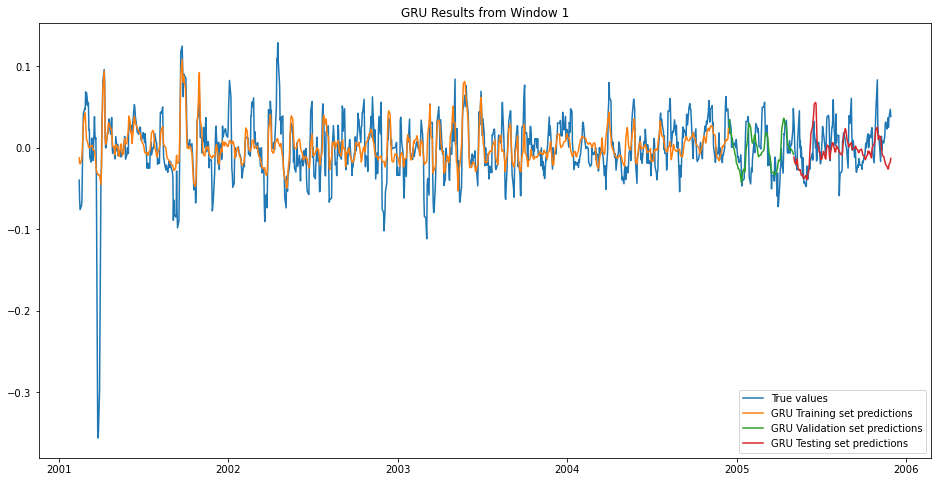

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0010183957049962214
RMSE = 0.031912312749097664
MAE = 0.024502459532461482
R-Squared = 0.028365926398235874

Results on Validation set: 
MSE = 0.0006023820777062781
RMSE = 0.024543473220110437
MAE = 0.01976644770596612
R-Squared = -0.06010280603165019

Results on Testing set: 
MSE = 0.0012801918650622067
RMSE = 0.0357797689352825
MAE = 0.02728024417818573
R-Squared = 0.01631646031663847



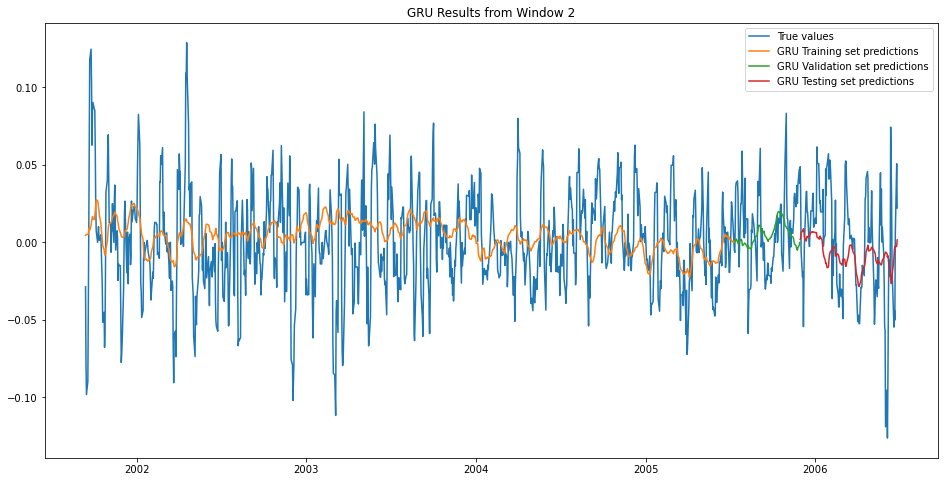

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0008761393651943493
RMSE = 0.02959965143704144
MAE = 0.022685549578640357
R-Squared = 0.040255886424792164

Results on Validation set: 
MSE = 0.0010341010820223394
RMSE = 0.03215744209389701
MAE = 0.02452415757723939
R-Squared = 0.21236539743980098

Results on Testing set: 
MSE = 0.0006340506544180543
RMSE = 0.02518036247590678
MAE = 0.020133945976611157
R-Squared = 0.1231058042737534



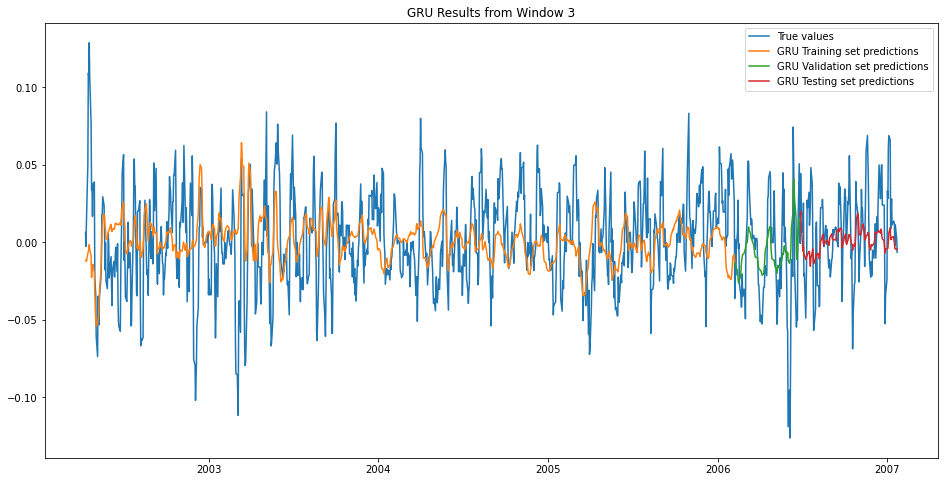

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0005430764442589442
RMSE = 0.023304000606311014
MAE = 0.017418469935400097
R-Squared = 0.39971156082891557

Results on Validation set: 
MSE = 0.0005635262621127633
RMSE = 0.023738708096961877
MAE = 0.017418655584239894
R-Squared = 0.20641706368931834

Results on Testing set: 
MSE = 0.0019172163771750462
RMSE = 0.04378602947487984
MAE = 0.0359308116593734
R-Squared = -0.9482582819689109



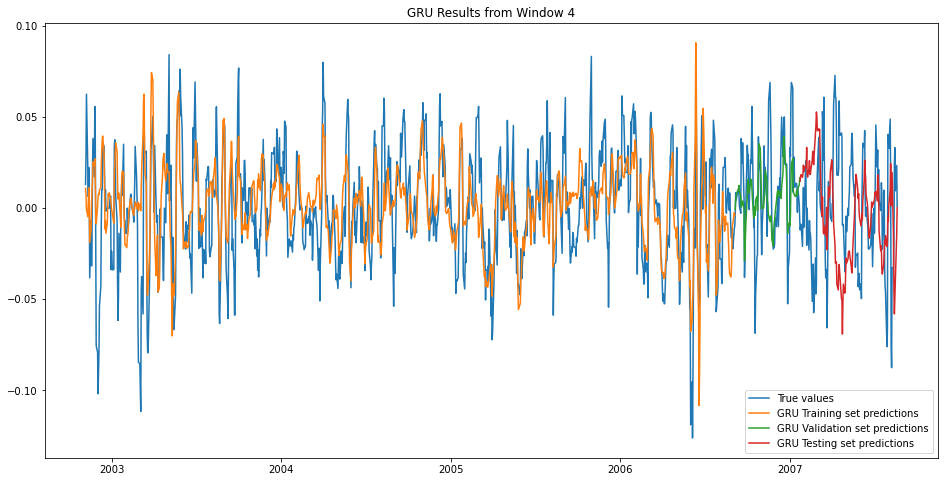

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0007326274803014531
RMSE = 0.027067092202552035
MAE = 0.0213331549996456
R-Squared = 0.08156209308936702

Results on Validation set: 
MSE = 0.001107940734189566
RMSE = 0.033285743707923456
MAE = 0.027485480811800005
R-Squared = -0.04070172381918291

Results on Testing set: 
MSE = 0.0012719772198279613
RMSE = 0.035664789636670524
MAE = 0.028297875043344044
R-Squared = -0.039734290169054276



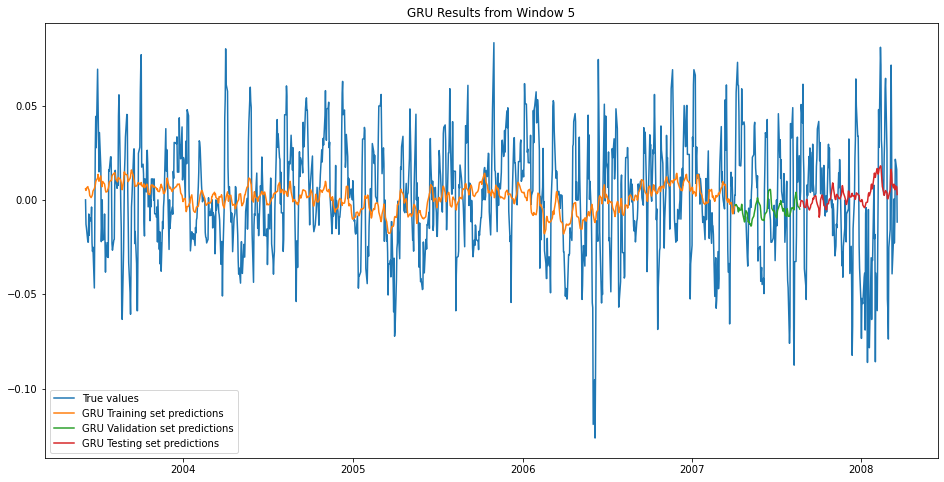

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0007454212104967796
RMSE = 0.027302403016891748
MAE = 0.02141430165817296
R-Squared = 0.09106418485168366

Results on Validation set: 
MSE = 0.0015889409658394222
RMSE = 0.0398615223723257
MAE = 0.03314848240558279
R-Squared = -0.09661291581080511

Results on Testing set: 
MSE = 0.0024432534756869055
RMSE = 0.04942927751532391
MAE = 0.03304436701426911
R-Squared = -0.014441111173359333



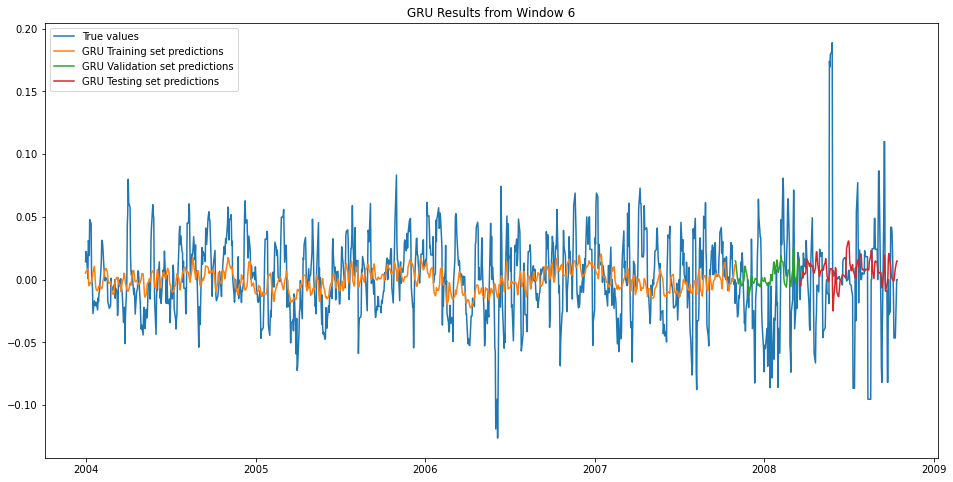

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0009532615192516052
RMSE = 0.03087493351007586
MAE = 0.023303925104195926
R-Squared = 0.11743874827763379

Results on Validation set: 
MSE = 0.0018247157510497168
RMSE = 0.04271669171471167
MAE = 0.030545884044897033
R-Squared = -0.05199485683782901

Results on Testing set: 
MSE = 0.0036971326195935675
RMSE = 0.060804051013016946
MAE = 0.04607177161559022
R-Squared = 0.06159260474002548



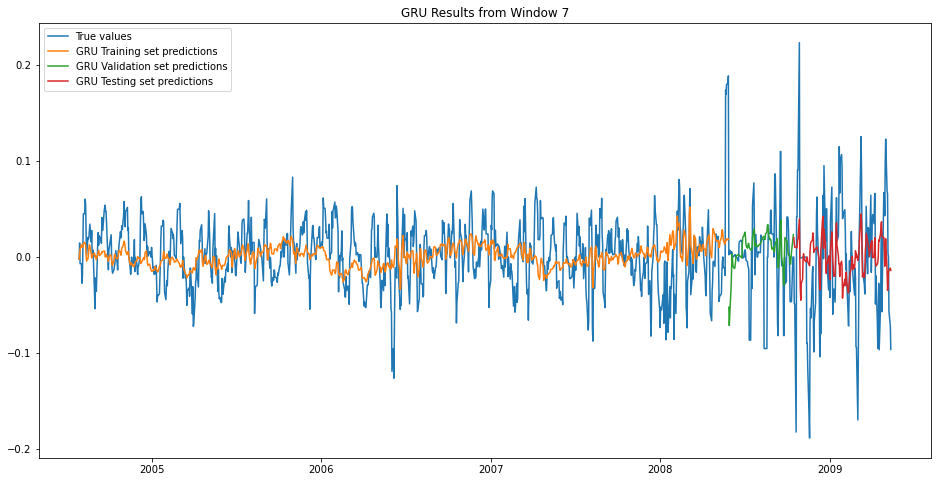

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0012846145555315174
RMSE = 0.03584151999471447
MAE = 0.02598681128451138
R-Squared = 0.09851931632505428

Results on Validation set: 
MSE = 0.003112429175591212
RMSE = 0.05578914926391343
MAE = 0.044611043822114047
R-Squared = 0.022853598358991922

Results on Testing set: 
MSE = 0.001054902698524416
RMSE = 0.03247926567095408
MAE = 0.02616519788018937
R-Squared = -0.0024377374916735306



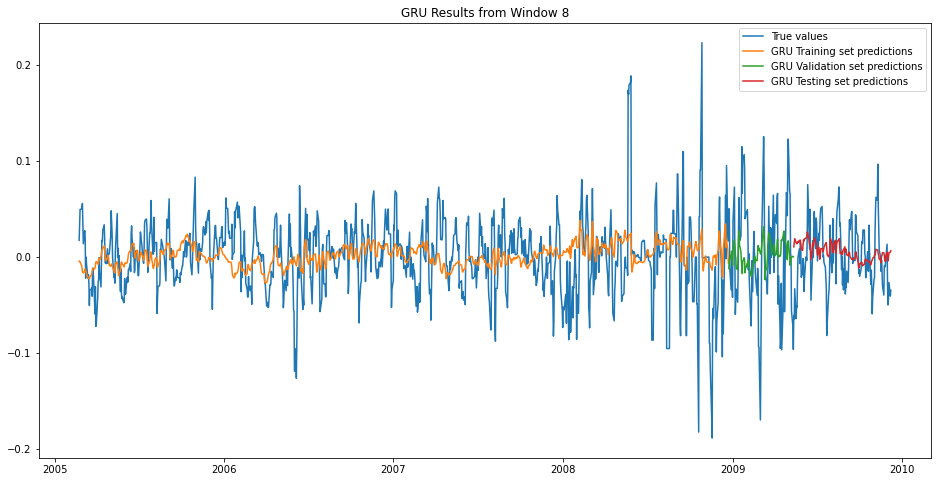

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0013964811692170134
RMSE = 0.03736952192920072
MAE = 0.026635686713477862
R-Squared = 0.16917680857208972

Results on Validation set: 
MSE = 0.0008783882814426001
RMSE = 0.029637615987838834
MAE = 0.023819482977441984
R-Squared = 0.17751439101626254

Results on Testing set: 
MSE = 0.0009982098677854285
RMSE = 0.03159445944759031
MAE = 0.025468667452316764
R-Squared = 0.11022532344082803



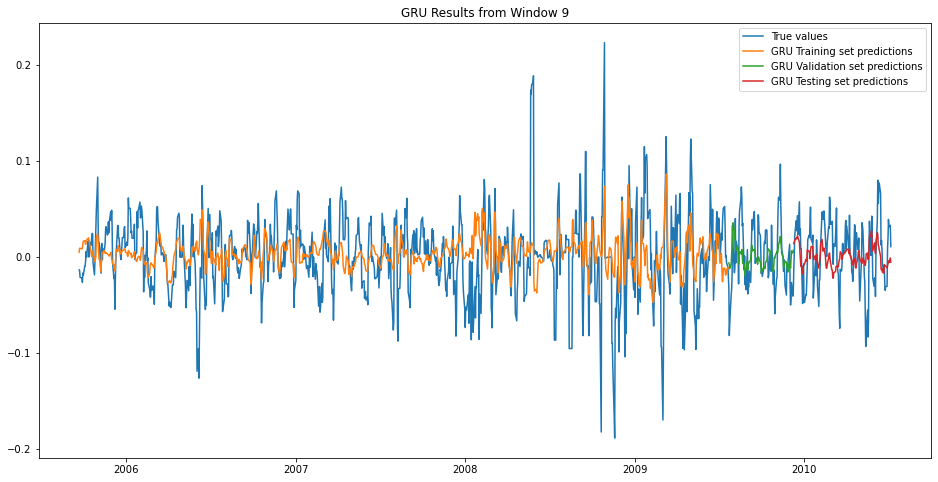

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0015800379975867535
RMSE = 0.039749691792349204
MAE = 0.028432761181345943
R-Squared = 0.07762975222644664

Results on Validation set: 
MSE = 0.0011824093244532398
RMSE = 0.034386179265123946
MAE = 0.027106684821986856
R-Squared = 0.03067466317313683

Results on Testing set: 
MSE = 0.0005705679948805202
RMSE = 0.023886565154507256
MAE = 0.019576989189074093
R-Squared = -0.16795339429500866



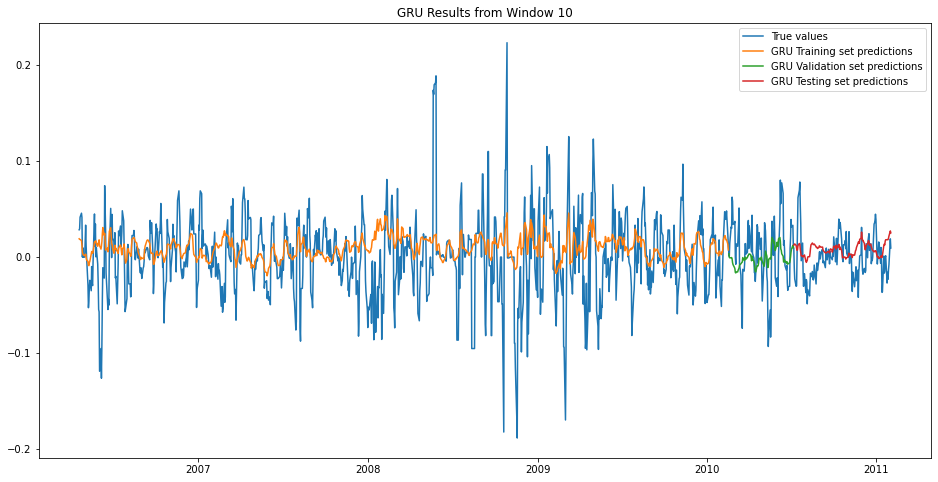

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.001396975524324326
RMSE = 0.0373761357596572
MAE = 0.026818712032792708
R-Squared = 0.18277970984381475

Results on Validation set: 
MSE = 0.0003145879443552062
RMSE = 0.01773662719784137
MAE = 0.013840445345845524
R-Squared = 0.08034716897071525

Results on Testing set: 
MSE = 0.0005945775709284572
RMSE = 0.024383961346107347
MAE = 0.01828384977102127
R-Squared = -0.053884685843690106



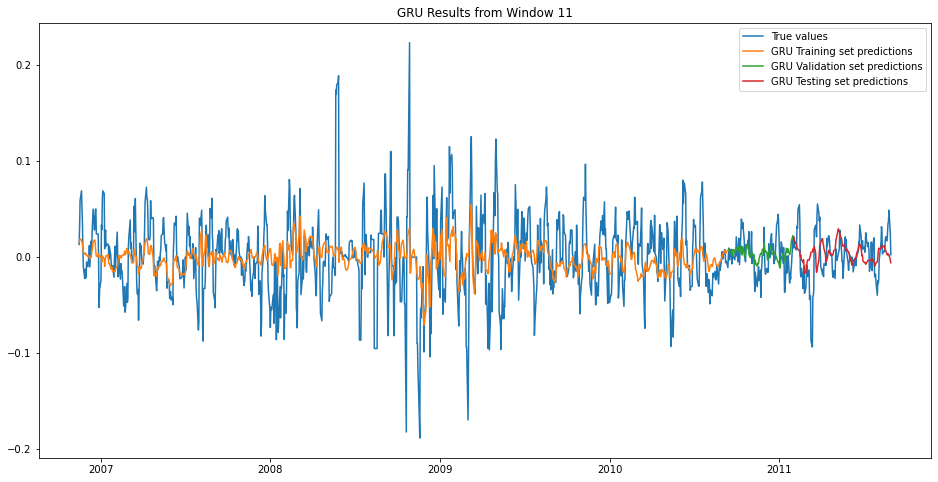

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.001634574833084569
RMSE = 0.04042987550171988
MAE = 0.029515349055571863
R-Squared = 0.010235785784225682

Results on Validation set: 
MSE = 0.00027376372080207574
RMSE = 0.016545806743766704
MAE = 0.013001038239261162
R-Squared = -0.03643492078245458

Results on Testing set: 
MSE = 0.00040989433420547216
RMSE = 0.020245847332366017
MAE = 0.016372461935933783
R-Squared = -0.07966754219527883



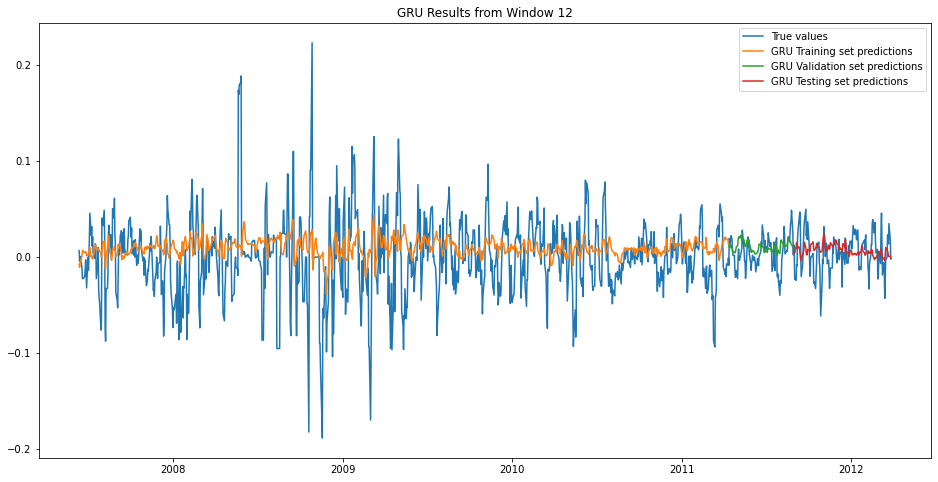

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0016545941205498042
RMSE = 0.040676702429643975
MAE = 0.028702206940230384
R-Squared = -0.05366828222600484

Results on Validation set: 
MSE = 0.0003500335561097877
RMSE = 0.01870918373713262
MAE = 0.015343382284259686
R-Squared = -0.18880828972526364

Results on Testing set: 
MSE = 0.0003341948181536239
RMSE = 0.01828099609303672
MAE = 0.014703520641482377
R-Squared = 0.020154944491400095



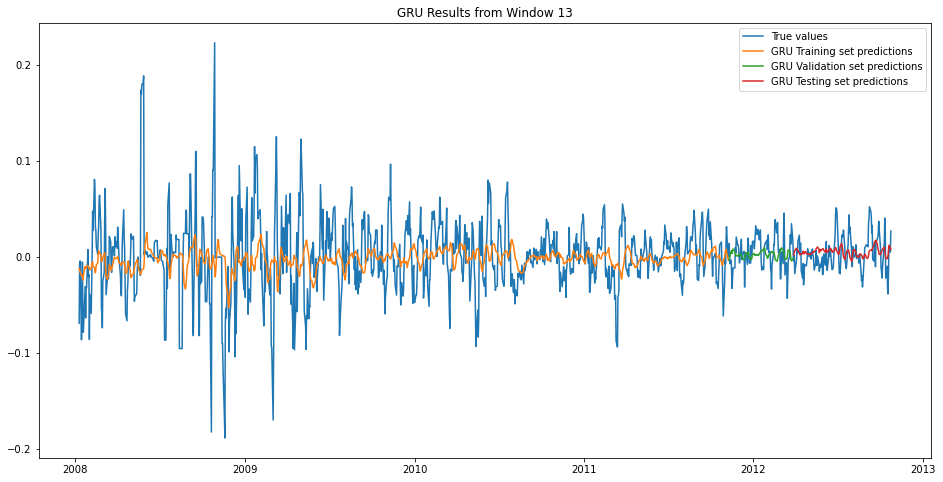

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.000839458185402509
RMSE = 0.028973404794785666
MAE = 0.021051535270540538
R-Squared = 0.34902246608308773

Results on Validation set: 
MSE = 0.0003627833993883875
RMSE = 0.01904687374317338
MAE = 0.015065884604786502
R-Squared = 0.13166081169834332

Results on Testing set: 
MSE = 0.0010856838610284359
RMSE = 0.0329497171615848
MAE = 0.02646989118013426
R-Squared = -0.5477929514111619



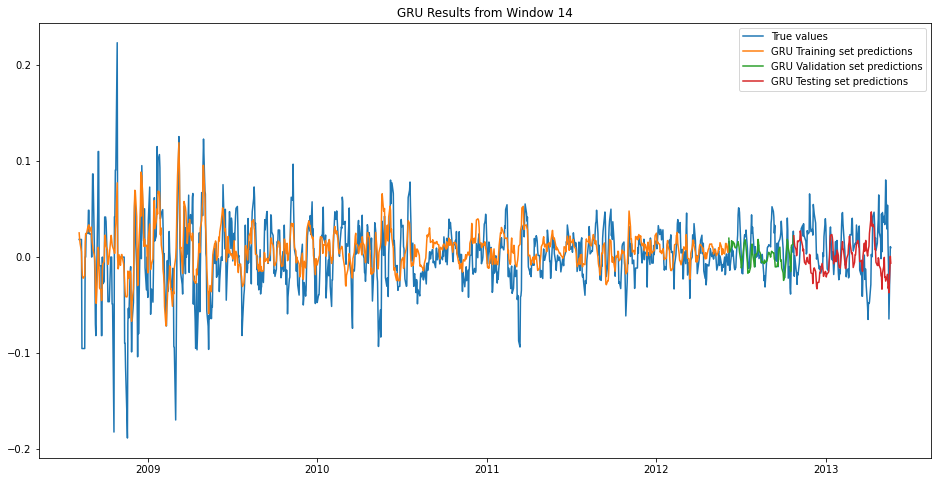

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0005750531520456682
RMSE = 0.023980265887718347
MAE = 0.01834451914863367
R-Squared = 0.2625140151169686

Results on Validation set: 
MSE = 0.0008492911812662397
RMSE = 0.029142600797908202
MAE = 0.022176094457709756
R-Squared = -0.07331002775596818

Results on Testing set: 
MSE = 0.0012528516438120897
RMSE = 0.0353956444186582
MAE = 0.026733300929339645
R-Squared = -0.44995381903688214



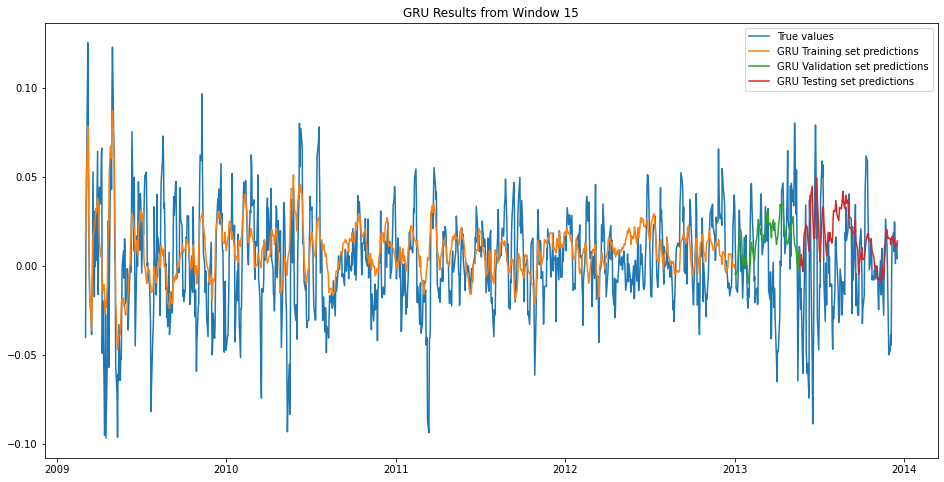

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0005941096727643879
RMSE = 0.024374365074077066
MAE = 0.018632616747136843
R-Squared = 0.1243030230037685

Results on Validation set: 
MSE = 0.0004965168063785574
RMSE = 0.022282657076268024
MAE = 0.01736473271763747
R-Squared = 0.07387003699840267

Results on Testing set: 
MSE = 0.0005237999931283414
RMSE = 0.022886677197189228
MAE = 0.01705844944404502
R-Squared = 0.032993125032378945



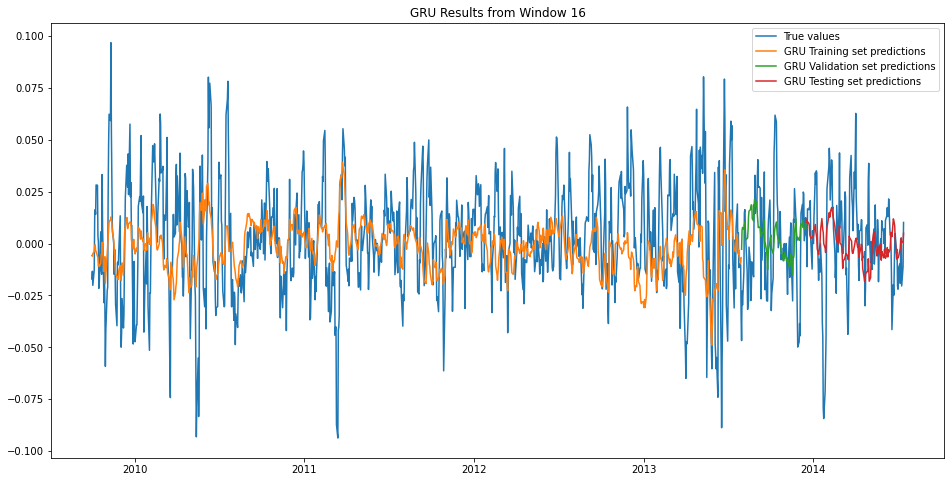

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0006048478312024413
RMSE = 0.024593654287283974
MAE = 0.018885209649968756
R-Squared = 0.06181469620641844

Results on Validation set: 
MSE = 0.00030411500804197245
RMSE = 0.01743889354408623
MAE = 0.013450498162175464
R-Squared = 0.09979924178934019

Results on Testing set: 
MSE = 0.0006739927627894646
RMSE = 0.025961370587653198
MAE = 0.0204220462435707
R-Squared = -0.1373813459346649



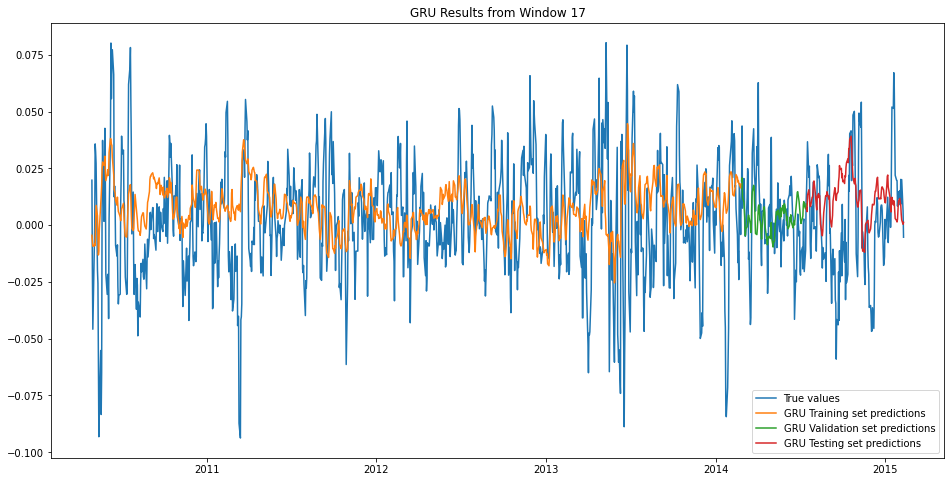

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0004382254845123752
RMSE = 0.020933835876694343
MAE = 0.016095043098376168
R-Squared = 0.21940128860544184

Results on Validation set: 
MSE = 0.0006137667608935451
RMSE = 0.02477431655754695
MAE = 0.019369203785072276
R-Squared = 0.05302730408395606

Results on Testing set: 
MSE = 0.002029834401072729
RMSE = 0.04505368354610674
MAE = 0.036581757562592174
R-Squared = -0.667282831426735



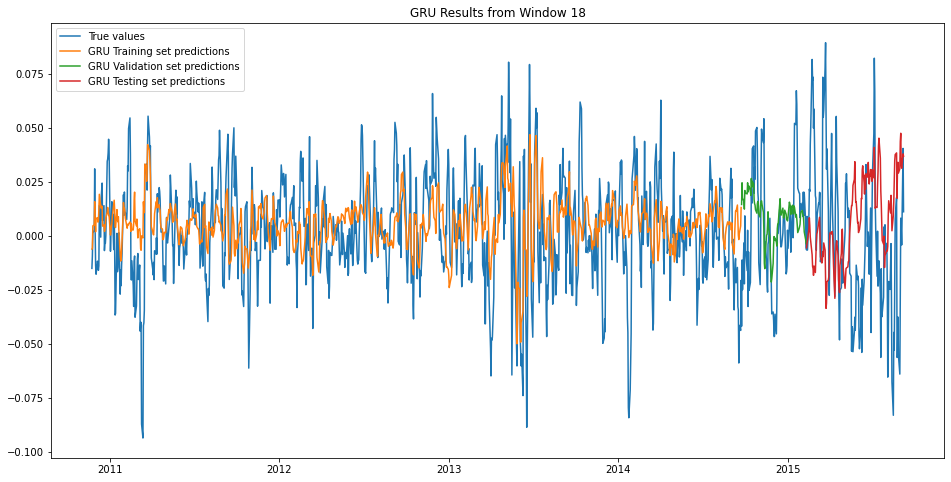

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0005851954851050385
RMSE = 0.024190814064537772
MAE = 0.018546603400302803
R-Squared = 0.035462259679832964

Results on Validation set: 
MSE = 0.0011260086600427368
RMSE = 0.033556052509834004
MAE = 0.027416376054960584
R-Squared = -0.3293489833322669

Results on Testing set: 
MSE = 0.0020363455768393915
RMSE = 0.0451258858842615
MAE = 0.03490439840521717
R-Squared = -0.04334431478985046



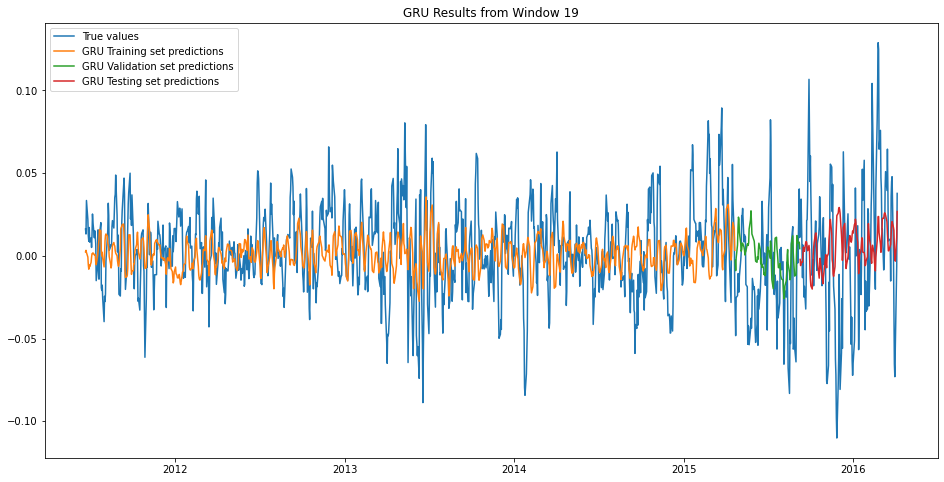

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0006934426451496296
RMSE = 0.026333299169485576
MAE = 0.02011189511439747
R-Squared = 0.0556043396353888

Results on Validation set: 
MSE = 0.002197280372196445
RMSE = 0.046875157303164806
MAE = 0.036931021326942426
R-Squared = 0.045829638231030145

Results on Testing set: 
MSE = 0.0011035579528140148
RMSE = 0.03321984275721387
MAE = 0.026513837209316767
R-Squared = -0.14972003029758207



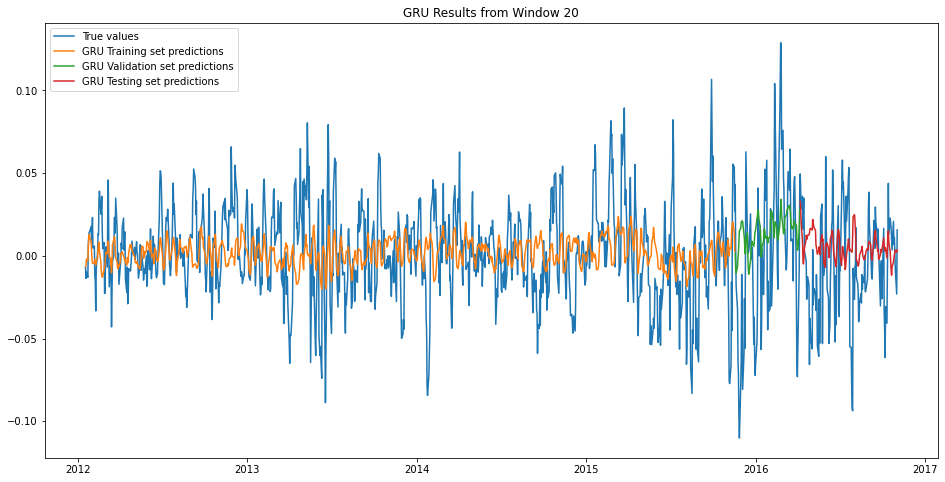

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0008711230611058435
RMSE = 0.029514793936360854
MAE = 0.02263146803479664
R-Squared = 0.10962992628241242

Results on Validation set: 
MSE = 0.0009410771219671947
RMSE = 0.030676980326740027
MAE = 0.023051844115777823
R-Squared = -0.02549105263026674

Results on Testing set: 
MSE = 0.0014828465665899862
RMSE = 0.03850774683865554
MAE = 0.03036913594017782
R-Squared = -0.16633034454122764



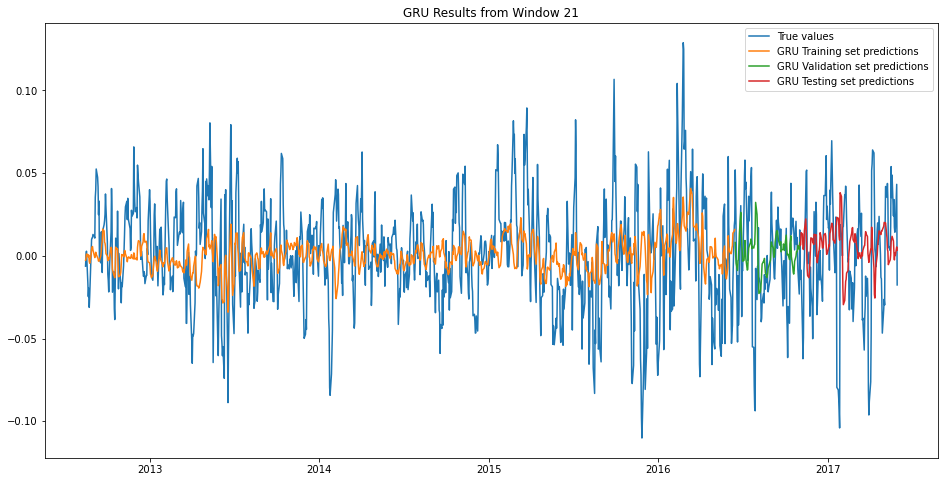

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0009814200195301932
RMSE = 0.03132762390495317
MAE = 0.02407625841279533
R-Squared = 0.05663064984157695

Results on Validation set: 
MSE = 0.0014953100604685645
RMSE = 0.03866923920209143
MAE = 0.029804836634353567
R-Squared = -0.057414644503276824

Results on Testing set: 
MSE = 0.0007985957404202194
RMSE = 0.028259436307545474
MAE = 0.0213306186837912
R-Squared = -0.0029072582678224546



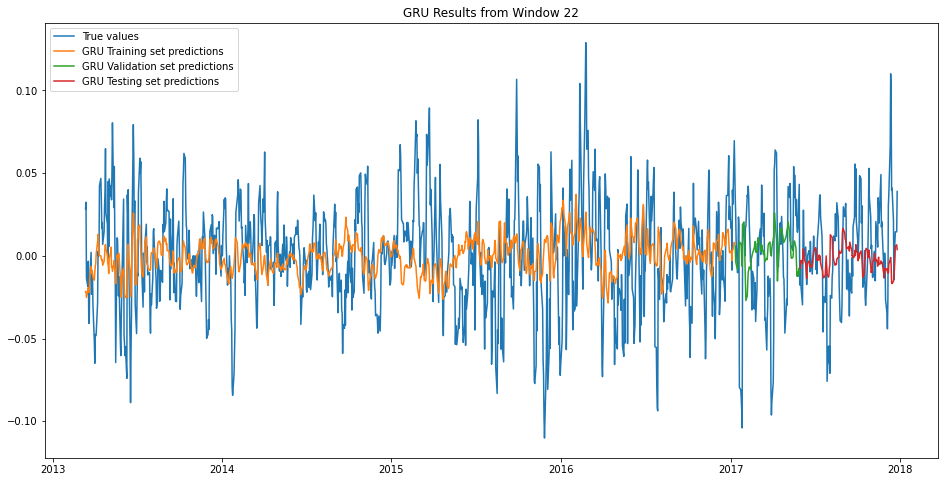

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0010179959246970813
RMSE = 0.03190604840303922
MAE = 0.024098196941211382
R-Squared = 0.03400741247820305

Results on Validation set: 
MSE = 0.0007017230631177939
RMSE = 0.02649005592892914
MAE = 0.020703405803611276
R-Squared = 0.08785767270787637

Results on Testing set: 
MSE = 0.0012260166303703641
RMSE = 0.03501452027902659
MAE = 0.027451297853530492
R-Squared = -0.007467604933898864



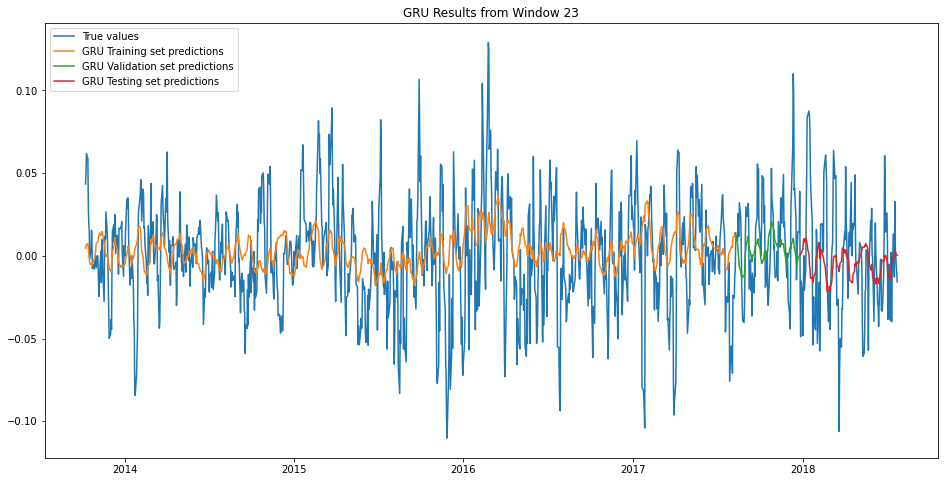

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0010683242953819473
RMSE = 0.03268523053891386
MAE = 0.02489553169846434
R-Squared = 0.05041597057879599

Results on Validation set: 
MSE = 0.000922587267244281
RMSE = 0.03037412167033445
MAE = 0.02347153863549957
R-Squared = 0.0009349335556555483

Results on Testing set: 
MSE = 0.0009986534277136975
RMSE = 0.03160147825203273
MAE = 0.025444563893083826
R-Squared = 0.044276523547851054



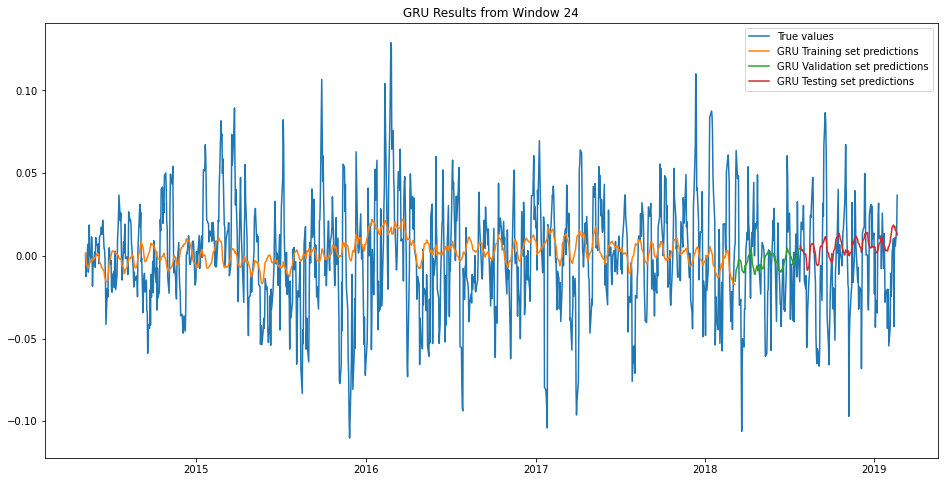

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4919

Results on Training set: 
MSE = 0.0011364396542968805
RMSE = 0.033711120632469053
MAE = 0.026220851138823692
R-Squared = 0.07781854480970019

Results on Validation set: 
MSE = 0.0007555342938897559
RMSE = 0.027486984081374878
MAE = 0.02185757293506978
R-Squared = 0.01929065958771259

Results on Testing set: 
MSE = 0.0009064046725877418
RMSE = 0.030106555309230277
MAE = 0.02332979931568508
R-Squared = -0.09258421639281766



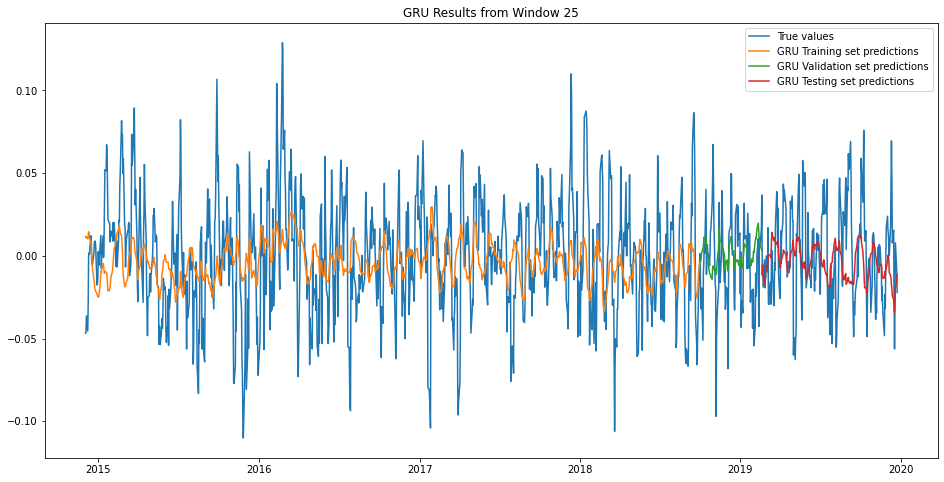

In [10]:
#Declaring model parameters
sequencelength = 199
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
gru_predictions = np.zeros((numPredictions + extra,1)) 
gru_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test GRU 
  gru_model = create_gru()
  gru_history, gru_model = train_gru(gru_model, x_train, y_train, x_val, y_val)
  gru_predictions, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions = makePredictions(gru_model, gru_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions)

  gru_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['GRU Train Predictions'] = gru_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['GRU Val Predictions'] = gru_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['GRU Test Predictions'] = gru_testingPredictions
  
  #Plot GRU Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['GRU Train Predictions'], label = 'GRU Training set predictions')
  plt.plot(valGraph['GRU Val Predictions'], label = 'GRU Validation set predictions')
  plt.plot(testGraph['GRU Test Predictions'], label = 'GRU Testing set predictions')
  plt.title("GRU Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

**Naive and Drift Forecasting Implementation**

In [11]:
def naiveForecasts(dataset, begin, horizon, testingSize):
  '''
  Naive forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    testingSize - Size of the test set
  @returns:
    naive - forecasts for the window
  '''
  naive = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  return naive.reshape((naive.shape[0],1))

def driftForecasts(dataset, begin, horizon, testingSize):
  '''
  Drift forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    horizon - Size of the forecasting Horizon
    testingSize - Size of the test set
  @returns:
    drift - forecasts for the window
  '''
  drift = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  for i in range(2, drift.shape[0] + 1): 
    drift[i - 1] = drift[i - 1] + horizon * ((drift[i - 1] - drift[0]) / (i - 1))
  return drift.reshape((drift.shape[0],1))

#Declaring model parameters
sequencelength = 100
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength 
naive_predictions = np.zeros((numPredictions + extra,1)) 
drift_predictions = np.zeros((numPredictions + extra,1)) 
target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #naive and drift forecasts
  begin = start + trainingSize + validationSize
  naive_predictions[start - sequencelength: start - sequencelength + testingSize, :] = naiveForecasts(dataset, begin, forecastHorizon, testingSize)
  drift_predictions[start - sequencelength: start - sequencelength + testingSize, :] = driftForecasts(dataset, begin, forecastHorizon, testingSize)
  target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Update window parameters
  start += testingSize
  end += testingSize

print("Naive and Drift Forecasts completed")

Naive and Drift Forecasts completed


**Overall Results**

In [12]:
def overall(actual, predictions, model):
  '''
  Calculate the overall performance of the model
  @params:
    actual - True Values
    predictions - Predicted Values
    model - Name of the model used
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print(model + " results on the Testing set")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

#Performance Metrics
overall(lstm_target, lstm_predictions, "LSTM model")
overall(gru_target, gru_predictions, "GRU model")
overall(target, naive_predictions, "Naive model")
overall(target, drift_predictions, "Drift model")

#For Plots
numpreds = 0
if lstm_predictions.shape[0] <= gru_predictions.shape[0]:
  numpreds = lstm_predictions.shape[0]
else:
  numpreds = gru_predictions.shape[0]

testGraph = pd.DataFrame(df[-numpreds:]['Target'])
testGraph['LSTM'] = lstm_predictions[-numpreds:]
testGraph['GRU'] = gru_predictions[-numpreds:]
testGraph['Naive'] = naive_predictions[-numpreds:]
testGraph['Drift'] = drift_predictions[-numpreds:]

LSTM model results on the Testing set
MSE = 0.002473438999361336
RMSE = 0.049733680734099464
MAE = 0.030135194350641516
R-Squared = -1.2645583481989324

GRU model results on the Testing set
MSE = 0.001196207563863869
RMSE = 0.034586233733436035
MAE = 0.025921347945514837
R-Squared = -0.09462361987505297

Naive model results on the Testing set
MSE = 0.002387855922850941
RMSE = 0.048865692697954675
MAE = 0.03646370883325597
R-Squared = -1.2003464194961015

Drift model results on the Testing set
MSE = 0.003007277451176772
RMSE = 0.054838649246464595
MAE = 0.0402608999964249
R-Squared = -1.771127063741707



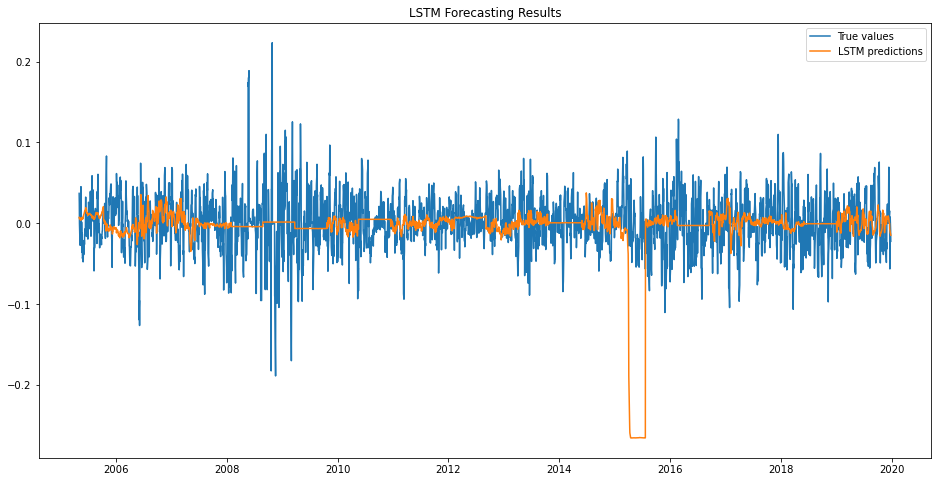

In [13]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['LSTM'], label = 'LSTM predictions')
plt.title("LSTM Forecasting Results")
plt.legend()
plt.show()

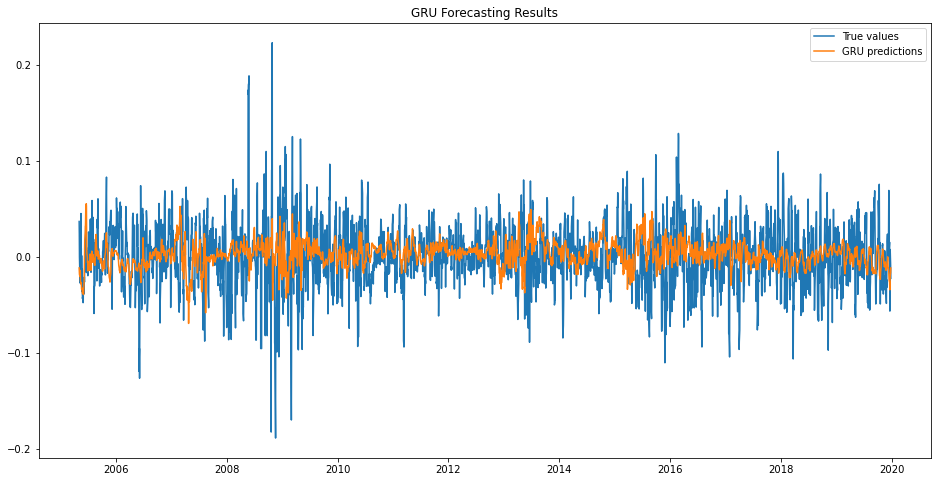

In [14]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['GRU'], label = 'GRU predictions')
plt.title("GRU Forecasting Results")
plt.legend()
plt.show()

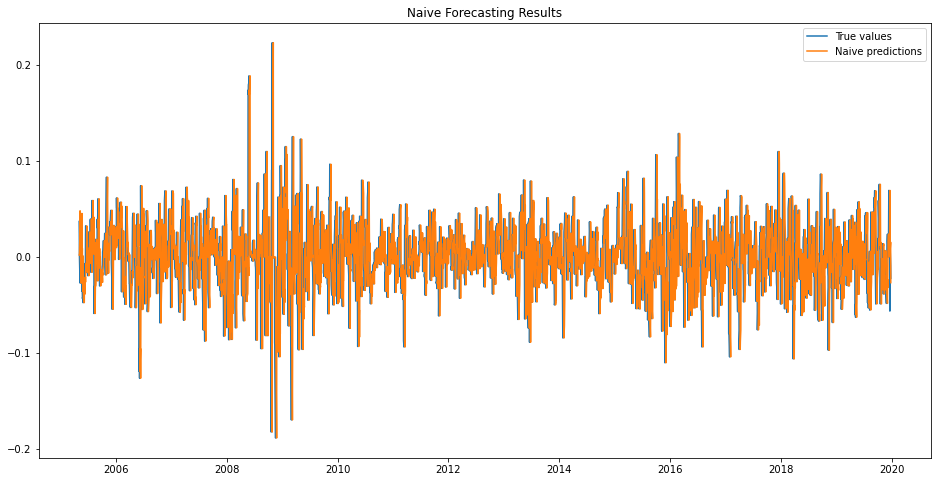

In [15]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Naive'], label = 'Naive predictions')
plt.title("Naive Forecasting Results")
plt.legend()
plt.show()

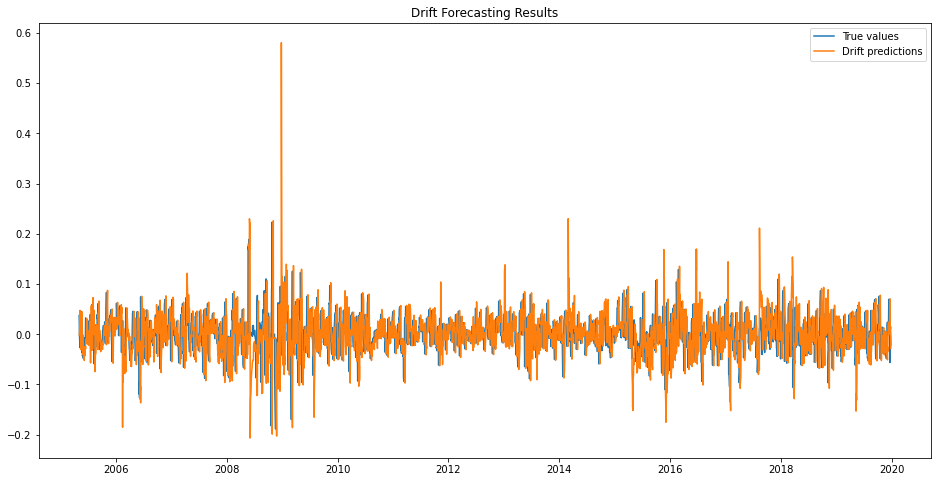

In [16]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Drift'], label = 'Drift predictions')
plt.title("Drift Forecasting Results")
plt.legend()
plt.show()

**Save the predictions to a csv file**

In [17]:
savePredictions = pd.DataFrame(df[-numpreds:]['Target'])

savePredictions['LBH LSTM'] = lstm_predictions[-numpreds:]
savePredictions['LBH GRU'] = gru_predictions[-numpreds:]
savePredictions['LBH Naive'] = naive_predictions[-numpreds:]
savePredictions['LBH Drift'] = drift_predictions[-numpreds:]
savePredictions.drop(['Target'], axis=1, inplace=True)

savePredictions.to_csv(r'./LBH_Predictions.csv', index=True, header=True)

In [18]:
savePredictions.head()

LBH LSTM   LBH GRU  LBH Naive  LBH Drift
Date                                                
2005-05-04  0.007429 -0.011326   0.002171  -0.000891
2005-05-05  0.007104 -0.014706   0.003091   0.000106
2005-05-06  0.005745 -0.018034   0.003711   0.000785
2005-05-09  0.006829 -0.020132   0.022060   0.020063
2005-05-10  0.006621 -0.016313   0.048195   0.047486